In [10]:
import os 
import pandas as pd
import numpy as np

from src.utils.dict_loader import TopicDictionary
from src.utils.output_loader import load_all_topvecs
from src.utils.downstream_aggregate import normalize

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]

START2016 = pd.to_datetime(configs["START2016"])
END2016 = pd.to_datetime(configs["END2016"])
START2020 = pd.to_datetime(configs["START2020"])
END2020 = pd.to_datetime(configs["END2020"])

INPUT_FPATH = configs["DATE_TOPVEC_PATH"]
print(f"INPUT_FPATH=={INPUT_FPATH}")

OUTPUT_FPATH = ROOTPATH + "output/figs/"
print(f"OUTPUT_FPATH=={OUTPUT_FPATH}")

INPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/date-topvec-min2-gtm1/
OUTPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/figs/


In [11]:
from src.utils.dict_configuration import dictionary2016, dictionary2020
year = 2016
if year == 2016:
    cand1 = "trump"
    cand2 = "clinton"
    dictionary = dictionary2016
elif year == 2020:
    cand1 = "biden"
    cand2 = "trump"
    dictionary = dictionary2020

In [12]:
ABBR_MAP = {
    "healthcare":"HLTH", 
    "election_campaign":"ELEC", 
    "general_controversies":"GENC", 
    "trump_controversies":"TRUC", 
    "civil_rights":"CIVR", 
    "crime":"CRIM", 
    "clinton_controversies":"CLIC", 
    "biden_controversies":"BIDC",
    "intl_affairs":"INTL", 
    "government_ops":"GVOP", 
    "energy":"ENRG", 
    "economy":"ECON", 
    "sstc":"SSTC", 
    "foreign_trade":"FRTR", 
    "immigration":"IMMI", 
    "social_welfare":"SOWL", 
    "education":"EDUC", 
    "environment":"ENVR", 
    "labour":"LABR", 
    "defence":"DEFC", 
    "religion":"RELG", 
    "agriculture":"AGRI", 
    "housing":"HOUS", 
    "transportation":"TRSP", 
    "land_water_management":"LWMN", 
    "forestry":"FRST", 
    "culture":"CLTR", 
    "no_topic":"NA", 
}

COLORMAP = {
    "low-cred": "#E55807",
    "traditional": "#445069",
    "left": "#4A55A2",
    "right": "#B31312", 
    "DEM": "#4A55A2",
    "REP": "#B31312", 
}

TOPICS2DROP = [
    "election_campaign", "general_controversies", "no_topic", 
    "forestry", "land_water_management", "agriculture", "housing", 
    "transportation", "culture"]

TOPICS2DROP_IDX2016 = [dictionary2016.topic2index[x] for x in TOPICS2DROP]
TOPICS2DROP_IDX2020 = [dictionary2020.topic2index[x] for x in TOPICS2DROP]

In [13]:
topvecs_df2016 = load_all_topvecs(year=2016, topvec_fpath=INPUT_FPATH)
topvecs_df2020 = load_all_topvecs(year=2020, topvec_fpath=INPUT_FPATH)

# bstr_sum_topvecs2016 = load_all_sum_vectors(year=2016, sumvec_fpath=INPUT_FPATH, vector_type="topvecs", load_bstr=True)
# bstr_sum_topvecs2020 = load_all_sum_vectors(year=2020, sumvec_fpath=INPUT_FPATH, vector_type="topvecs", load_bstr=True)

In [14]:
# LOAD EVENTS 
events = pd.read_csv(ROOTPATH + "index/events.tsv", sep="\t")
events["start_date"] = pd.to_datetime(events["start_date"])
events["end_date"] = pd.to_datetime(events["end_date"])
events["year"] = events["start_date"].map(lambda x: x.year)
events_2016 = events[events["year"]==2016].reset_index()
events_2020 = events[events["year"]==2020].reset_index()

## Intermedia alignment:

Does the topic align over time?

In [15]:
# import matplotlib.cm as cm

# TOPIC = "healthcare"
# topic_idx = dictionary2016.topic2index[TOPIC]

# fig, ax = plt.subplots(figsize=(12,5))
# y1 = np.array(topvecs_df2016["headline"][1][3]["majority_topvec"].tolist())[:,topic_idx]
# y2 = np.array(topvecs_df2016["headline"][1][5]["majority_topvec"].tolist())[:,topic_idx]
# plt.plot(topvecs_df2016["headline"][1][3]["date"], y1)
# plt.plot(topvecs_df2016["headline"][1][3]["date"], y2)
# # y2 = np.array(topvecs_df2016["headline"][0][2]["majority_topvec"].tolist())[:,topic_idx]
# # plt.plot(topvecs_df2016["headline"][0][1], y1, color=COLORMAP["low-cred"], label="lowc")
# # plt.plot(topvecs_df2016["headline"][0][1], y2, color=COLORMAP["traditional"], label="trad")
# for i,row in events_2016.iterrows():
#     ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))

# plt.legend(bbox_to_anchor=(1.08, 1.05))

In [16]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def normalize(arr, smooth=0):
    return (np.array(arr)+smooth)/np.sum(np.array(arr)+smooth)

def get_correlation(arr1, arr2, idx2drop=[], corr_func=pearsonr):
    if len(idx2drop) > 0:
        arr1_clean = np.delete(arr1, idx2drop)
        arr2_clean = np.delete(arr2, idx2drop)
    else:
        arr1_clean = arr1
        arr2_clean = arr2
    arr1_clean = normalize(arr1_clean)
    arr2_clean = normalize(arr2_clean)
    corr, p = corr_func(arr1_clean, arr2_clean)
    return corr, p

In [17]:
def agenda_alignment_tmp(topvec_df1, topvec_df2, idx2drop):
    corrs = []
    for arr1, arr2 in zip(topvec_df1["majority_topvec"].tolist(), topvec_df2["majority_topvec"].tolist()):
        corr, p = get_correlation(arr1, arr2, idx2drop=idx2drop)
        corrs.append(corr)
    return corrs
    
corrs_cred1_2016 = agenda_alignment_tmp(topvecs_df2016["headline"][0][1], topvecs_df2016["headline"][0][2], TOPICS2DROP_IDX2016)
corrs_cred2_2016 = agenda_alignment_tmp(topvecs_df2016["headline"][1][1], topvecs_df2016["headline"][1][2], TOPICS2DROP_IDX2016)

corrs_ideo1_2016 = agenda_alignment_tmp(topvecs_df2016["headline"][0][3], topvecs_df2016["headline"][0][5], TOPICS2DROP_IDX2016)
corrs_ideo2_2016 = agenda_alignment_tmp(topvecs_df2016["headline"][1][3], topvecs_df2016["headline"][1][5], TOPICS2DROP_IDX2016)


corrs_cred1_2020 = agenda_alignment_tmp(topvecs_df2020["headline"][0][1], topvecs_df2020["headline"][0][2], TOPICS2DROP_IDX2020)
corrs_cred2_2020 = agenda_alignment_tmp(topvecs_df2020["headline"][1][1], topvecs_df2020["headline"][1][2], TOPICS2DROP_IDX2020)

corrs_ideo1_2020 = agenda_alignment_tmp(topvecs_df2020["headline"][0][3], topvecs_df2020["headline"][0][5], TOPICS2DROP_IDX2020)
corrs_ideo2_2020 = agenda_alignment_tmp(topvecs_df2020["headline"][1][3], topvecs_df2020["headline"][1][5], TOPICS2DROP_IDX2020)

## OLS: alignment with difference in topics

## Univariate OLS

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

dictionary = dictionary2020
topvecs_df = topvecs_df2020
y = corrs_ideo2_2020
df1 = topvecs_df["headline"][1][5]
df2 = topvecs_df["headline"][1][3]
df1["majority_topvec"] = df1["majority_topvec"].map(lambda x: normalize(x))
df2["majority_topvec"] = df2["majority_topvec"].map(lambda x: normalize(x))

data = pd.DataFrame()
data["Y"] = y
topics = []
r2s = []
coeffs = []
intercepts = []
ps = []
for t in dictionary.topics:
    if t not in TOPICS2DROP:
        data[f"X"] = np.array(df1["majority_topvec"].tolist())[:,dictionary.topic2index[t]] 
        data[f"X"] -= np.array(df2["majority_topvec"].tolist())[:,dictionary.topic2index[t]]
        model = smf.ols("Y ~ X", data).fit()
        topics.append(t)
        r2s.append(round(model.rsquared,4))
        intercepts.append(round(model.params.Intercept,4))
        coeffs.append(round(model.params.X,4))
        ps.append(round(model.pvalues.X,4))

output_df = pd.DataFrame()
output_df["topic"] = topics
output_df["r2"] = r2s
output_df["coeff"] = coeffs
output_df["const"] = intercepts
output_df["p-value"] = ps
output_df.sort_values(by="r2", ascending=False)

topic      r2   coeff   const  p-value
0            healthcare  0.4520  0.3817  0.9539   0.0000
7        government_ops  0.2913 -0.4029  0.9178   0.0000
10                 sstc  0.2464 -0.9607  0.9911   0.0000
14            education  0.1291  1.8162  0.9395   0.0000
15       social_welfare  0.0806  5.7017  0.9332   0.0004
13               labour  0.0713 -2.2454  0.9293   0.0009
9           immigration  0.0548  1.8365  0.9261   0.0037
11        foreign_trade  0.0403 -3.4842  0.9272   0.0132
4                energy  0.0353 -1.9664  0.9293   0.0204
6          intl_affairs  0.0338 -0.5139  0.9409   0.0233
12          environment  0.0244 -0.9693  0.9275   0.0547
3          civil_rights  0.0232 -0.2202  0.9275   0.0611
8               economy  0.0227  0.4459  0.9340   0.0640
1   biden_controversies  0.0168 -1.1736  0.9514   0.1116
2   trump_controversies  0.0092 -0.1019  0.9320   0.2405
5                 crime  0.0003 -0.0262  0.9317   0.8198
16             religion  0.0002  0.1607  0.9311   0.8765
17              defence  0.0001  0.0442  0.9311   0.8814

## Multivariate OLS

In [19]:
topic = "clinton_controversies"
dictionary = dictionary2016
topvecs_df = topvecs_df2016
df1 = topvecs_df2016["headline"][1][1]
df2 = topvecs_df2016["headline"][1][2]
df1["majority_topvec"] = df1["majority_topvec"].map(lambda x: normalize(x))
df2["majority_topvec"] = df2["majority_topvec"].map(lambda x: normalize(x))

Y = corrs_cred2_2016
X = np.array(df1["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
X -= np.array(df2["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]


In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

topic = "biden_controversies"
dictionary = dictionary2020
topvecs_df = topvecs_df2020
df1 = topvecs_df2020["headline"][0][1]
df2 = topvecs_df2020["headline"][0][2]
df1["majority_topvec"] = df1["majority_topvec"].map(lambda x: normalize(x))
df2["majority_topvec"] = df2["majority_topvec"].map(lambda x: normalize(x))

Y = corrs_cred1_2020
X = np.array(df1["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
X -= np.array(df2["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]

data = pd.DataFrame({"Y":Y, "X":X})
# result = sm.OLS(Y,X).fit()
# print(result.params)
# print(result.summary())
res = smf.ols("Y ~ X", data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     430.9
Date:                Sun, 31 Mar 2024   Prob (F-statistic):           5.99e-46
Time:                        17:59:30   Log-Likelihood:                 273.10
No. Observations:                 152   AIC:                            -542.2
Df Residuals:                     150   BIC:                            -536.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0863      0.012     87.838      0.0

## Visualizations

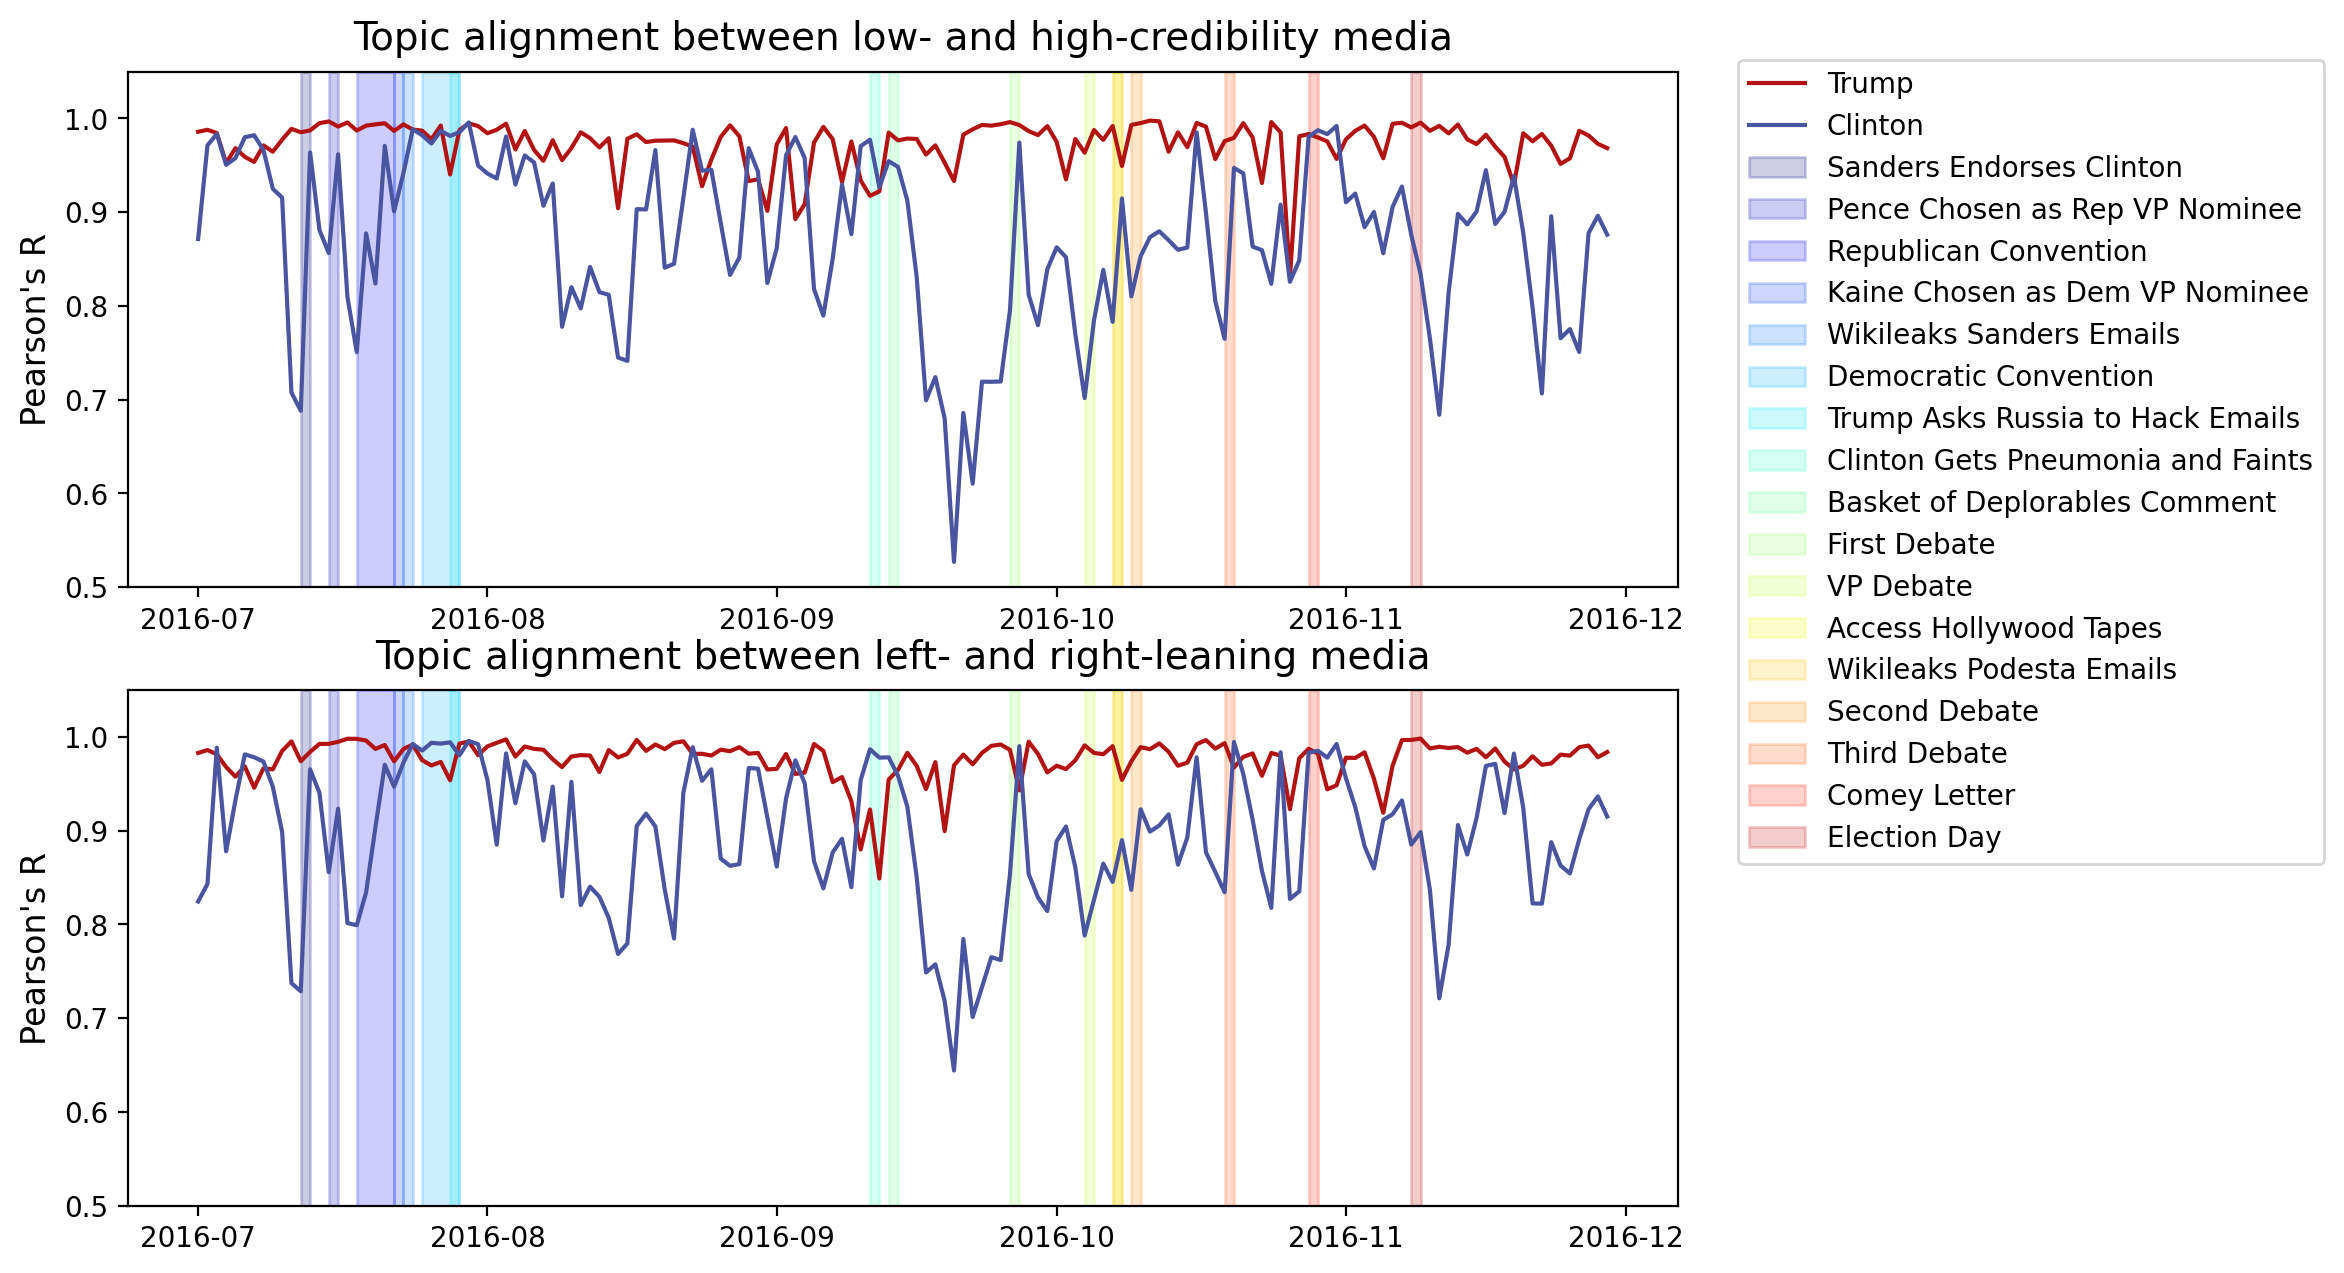

In [23]:
import matplotlib.cm as cm

dates = topvecs_df2016["headline"][0][1]["date"].tolist()
fig, ax = plt.subplots(figsize=(10,3), nrows=2)
ax[0].plot(dates, corrs_cred1_2016, color=COLORMAP["right"], label="Trump")
ax[0].plot(dates, corrs_cred2_2016, color=COLORMAP["left"], label="Clinton")
ax[1].plot(dates, corrs_ideo1_2016, color=COLORMAP["right"], label="Trump")
ax[1].plot(dates, corrs_ideo2_2016, color=COLORMAP["left"], label="Clinton")
for i,row in events_2016.iterrows():
    ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))
    ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))

for i in range(2):
    ax[i].set_ylim(.5,1.05)
    ax[i].set_ylabel("Pearson's R", fontsize=12)
# plt.ylabel("Pearson correlation", fontsize=16)
ax[0].set_title("Topic alignment between low- and high-credibility media", fontsize=14, y=1.01)
ax[1].set_title("Topic alignment between left- and right-leaning media", fontsize=14, y=1.01)
ax[-1].legend(bbox_to_anchor=(1.03, 2.25))
fig.subplots_adjust(top=2)
# plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + "tmp_topic_alignment_domains2016.pdf", dpi=300, bbox_inches="tight")

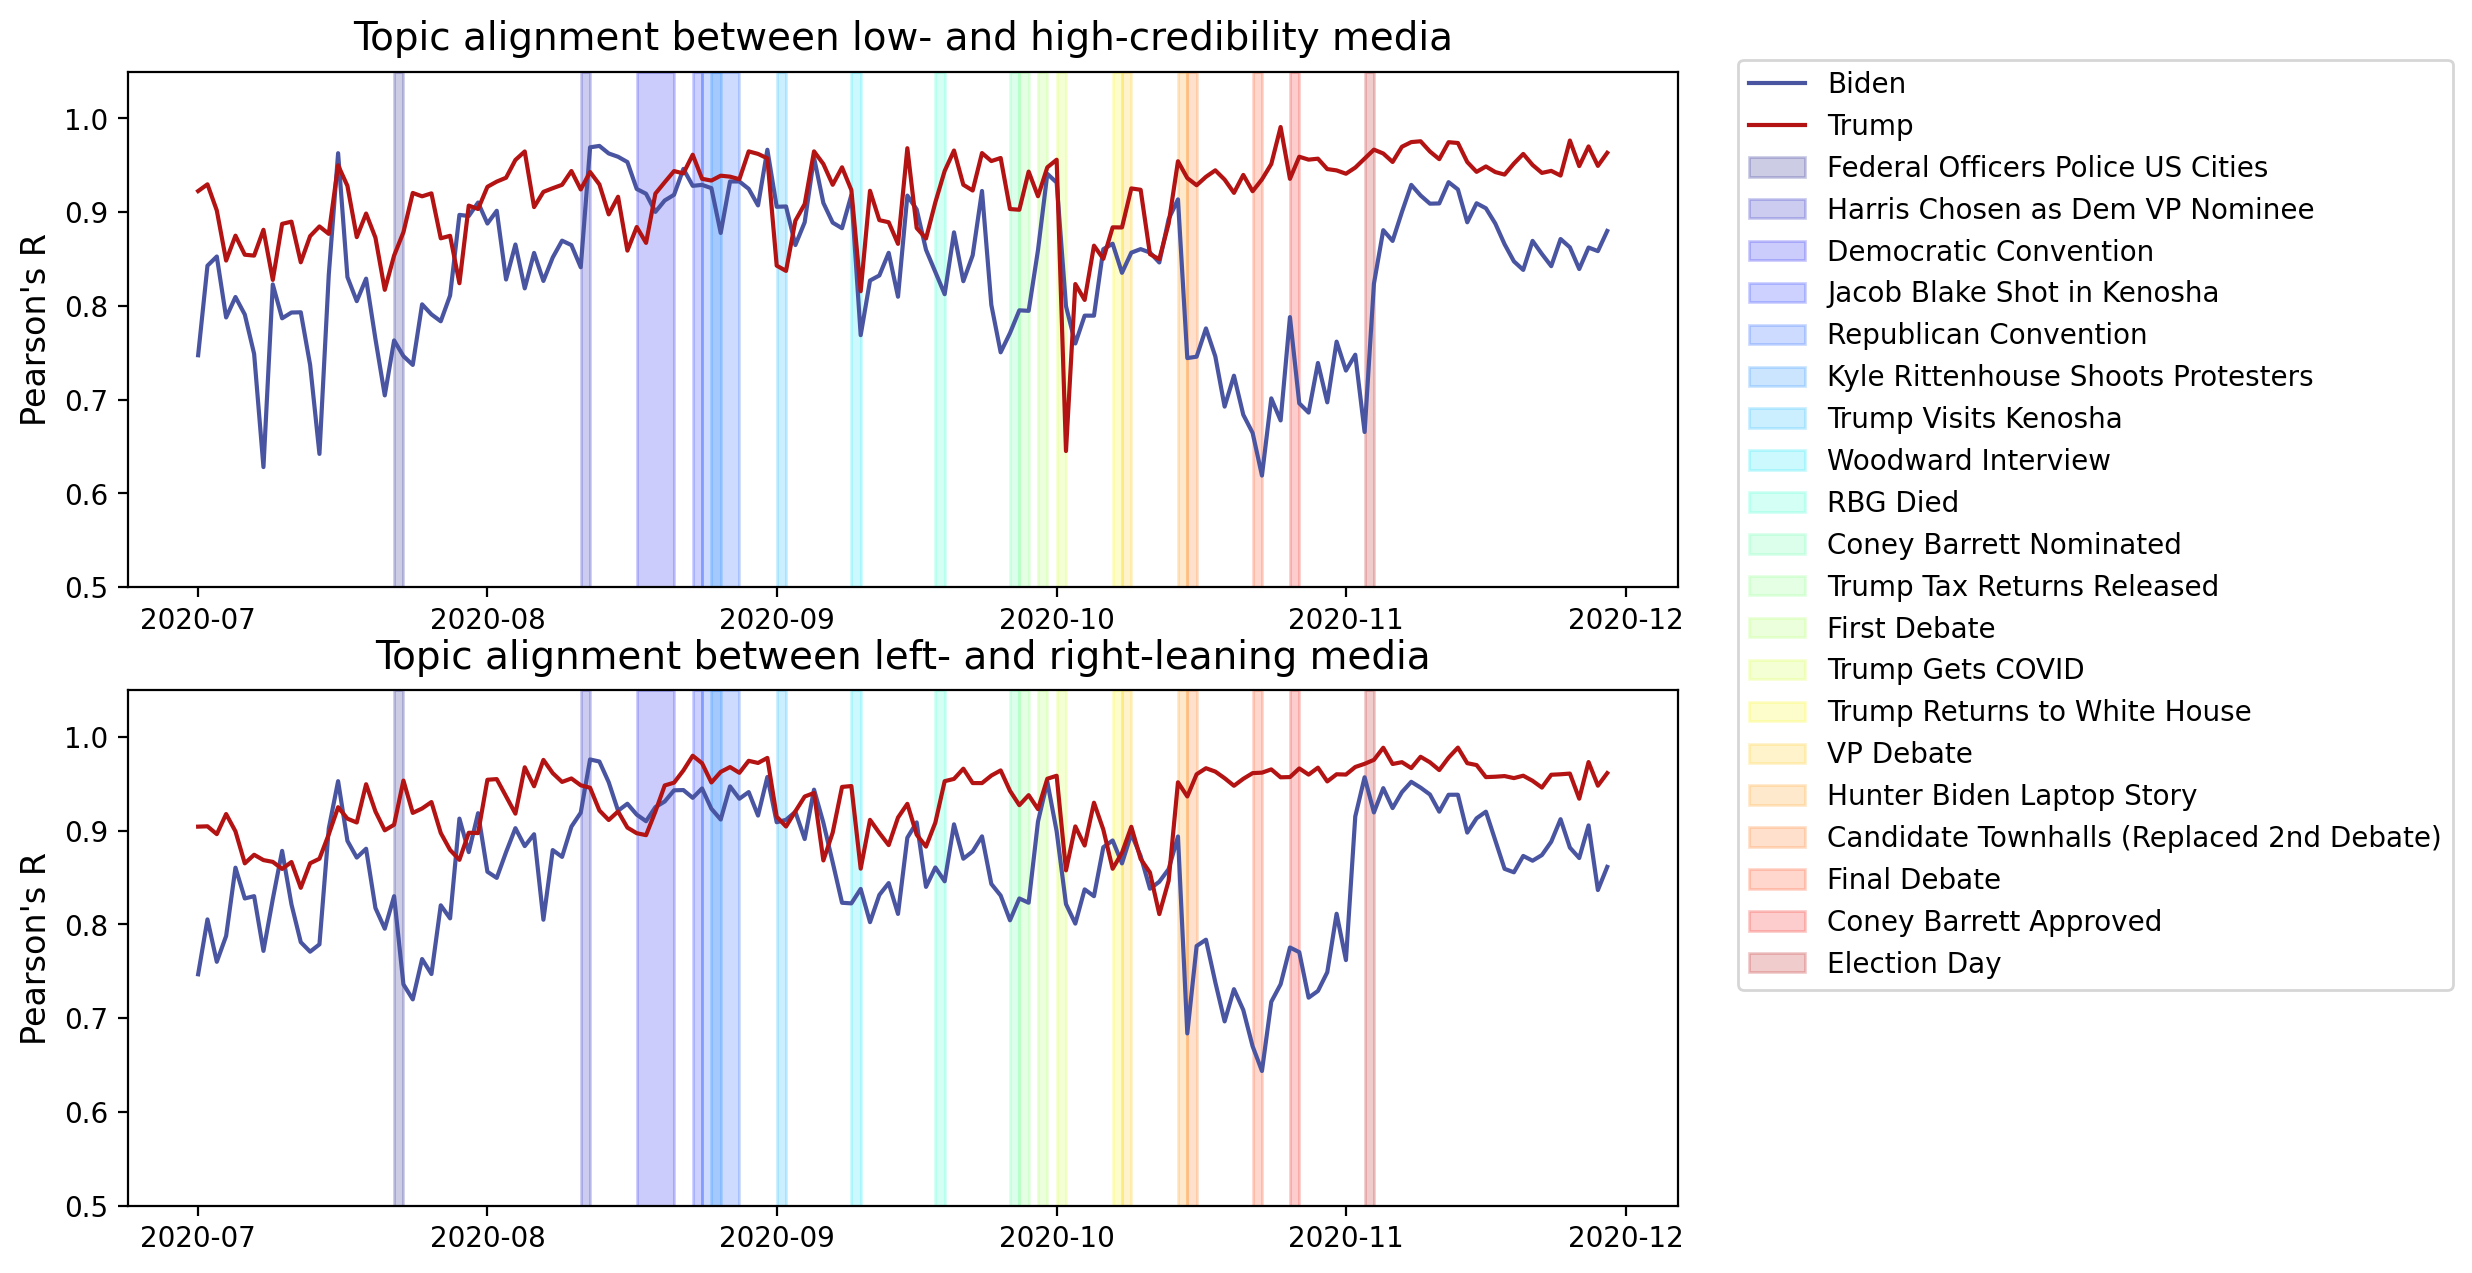

In [24]:
import matplotlib.cm as cm

dates = topvecs_df2020["headline"][0][1]["date"].tolist()
fig, ax = plt.subplots(figsize=(10,3), nrows=2)
ax[0].plot(dates, corrs_cred1_2020, color=COLORMAP["left"], label="Biden")
ax[0].plot(dates, corrs_cred2_2020, color=COLORMAP["right"], label="Trump")
ax[1].plot(dates, corrs_ideo1_2020, color=COLORMAP["left"], label="Biden")
ax[1].plot(dates, corrs_ideo2_2020, color=COLORMAP["right"], label="Trump")
for i,row in events_2020.iterrows():
    ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))
    ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))

for i in range(2):
    ax[i].set_ylim(.5,1.05)
    ax[i].set_ylabel("Pearson's R", fontsize=12)
# plt.ylabel("Pearson correlation", fontsize=16)
ax[0].set_title("Topic alignment between low- and high-credibility media", fontsize=14, y=1.01)
ax[1].set_title("Topic alignment between left- and right-leaning media", fontsize=14, y=1.01)
ax[-1].legend(bbox_to_anchor=(1.03, 2.25))
fig.subplots_adjust(top=2)
# plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + "tmp_topic_alignment_domains2020.pdf", dpi=300, bbox_inches="tight")

In [98]:
# import matplotlib.cm as cm

# dates = topvecs_df2016["headline"][0][1]["date"].tolist()
# fig, ax = plt.subplots(figsize=(12,4.8))
# plt.plot(dates, corrs_ideo1_2016, color=COLORMAP["right"], label="Trump")
# plt.plot(dates, corrs_ideo2_2016, color=COLORMAP["left"], label="Clinton")
# for i,row in events_2016.iterrows():
#     ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))
# plt.ylim(.4,1.05)
# plt.legend(bbox_to_anchor=(1.08, 1.05))
# plt.ylabel("Pearson correlation", fontsize=16)
# plt.title("Topic alignment over time between left-leaning and right-leaning media", fontsize=16, pad=10)
# plt.xticks(fontsize=14)
# plt.savefig(OUTPUT_FPATH + "tmp_topic_alignment_ideo_domains2016.pdf", dpi=300, bbox_inches="tight")

In [12]:
# df = pd.DataFrame()
# df["topic"] = dictionary2016.topics
# df["prop_left"] = topvecs_df2016["headline"][1][3].loc[67]["majority_topvec"]
# df["prop_right"] = topvecs_df2016["headline"][1][5].loc[67]["majority_topvec"]
# print(get_correlation(topvecs_df2016["headline"][1][3].loc[67]["majority_topvec"], 
# topvecs_df2016["headline"][1][5].loc[67]["majority_topvec"], TOPICS2DROP_IDX2016
# ))
# df.sort_values(by="prop_left")

In [13]:
# df = pd.DataFrame()
# df["topic"] = dictionary2016.topics
# df["prop_left"] = topvecs_df2016["headline"][1][3].loc[72]["majority_topvec"]
# df["prop_right"] = topvecs_df2016["headline"][1][5].loc[72]["majority_topvec"]
# print(get_correlation(topvecs_df2016["headline"][1][3].loc[72]["majority_topvec"], 
# topvecs_df2016["headline"][1][5].loc[72]["majority_topvec"], TOPICS2DROP_IDX2016
# ))
# df.sort_values(by="prop_left")

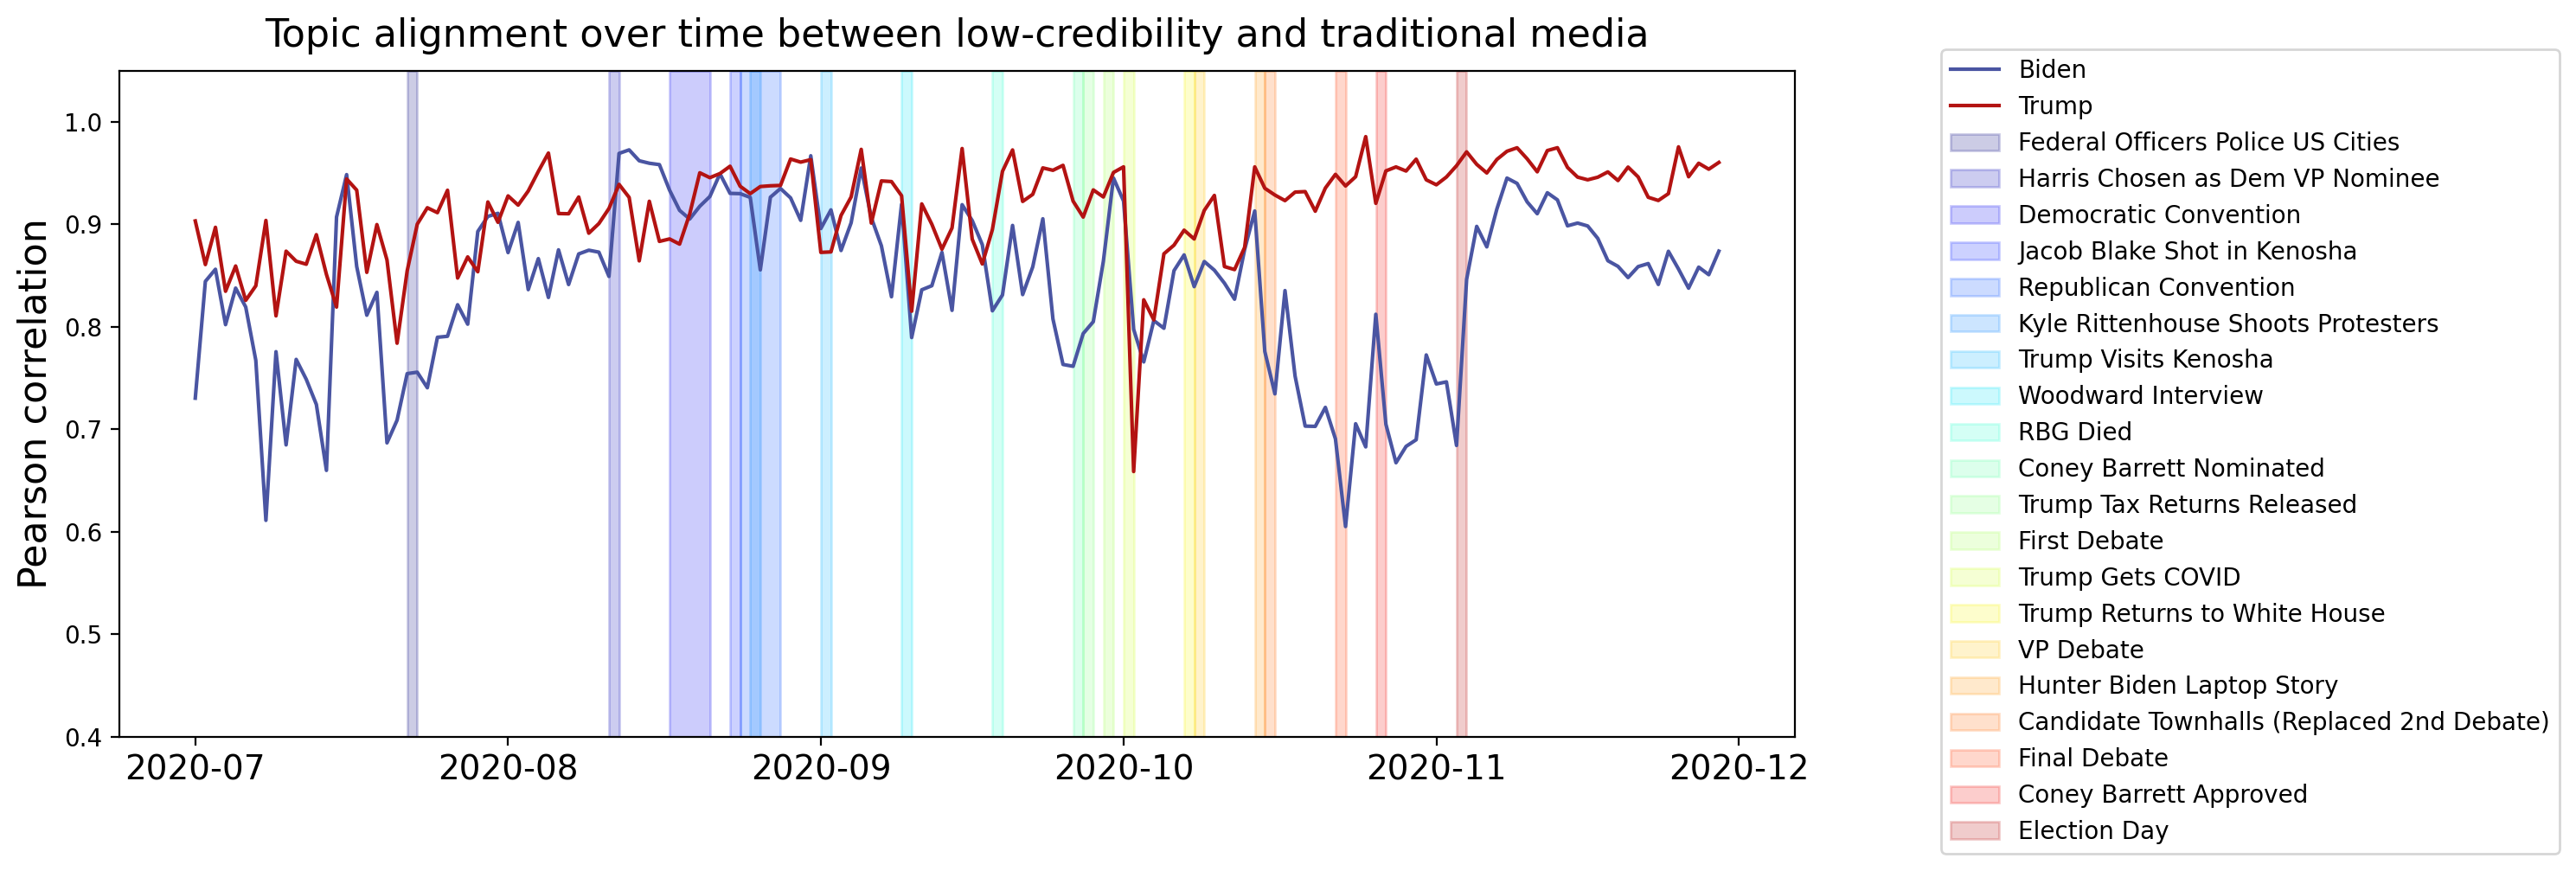

In [24]:
import matplotlib.cm as cm

dates = topvecs_df2020["headline"][0][1]["date"].tolist()

fig, ax = plt.subplots(figsize=(12.5,5))
plt.plot(dates, corrs_cred1_2020, color=COLORMAP["left"], label="Biden")
plt.plot(dates, corrs_cred2_2020, color=COLORMAP["right"], label="Trump")
for i,row in events_2020.iterrows():
    ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))
plt.ylim(.4,1.05)
plt.legend(bbox_to_anchor=(1.08, 1.05))
plt.ylabel("Pearson correlation", fontsize=16)
plt.title("Topic alignment over time between low-credibility and traditional media", fontsize=16, pad=10)
plt.xticks(fontsize=14)
plt.savefig(OUTPUT_FPATH + "tmp_topic_alignment_cred_domains2020.pdf", dpi=300, bbox_inches="tight")

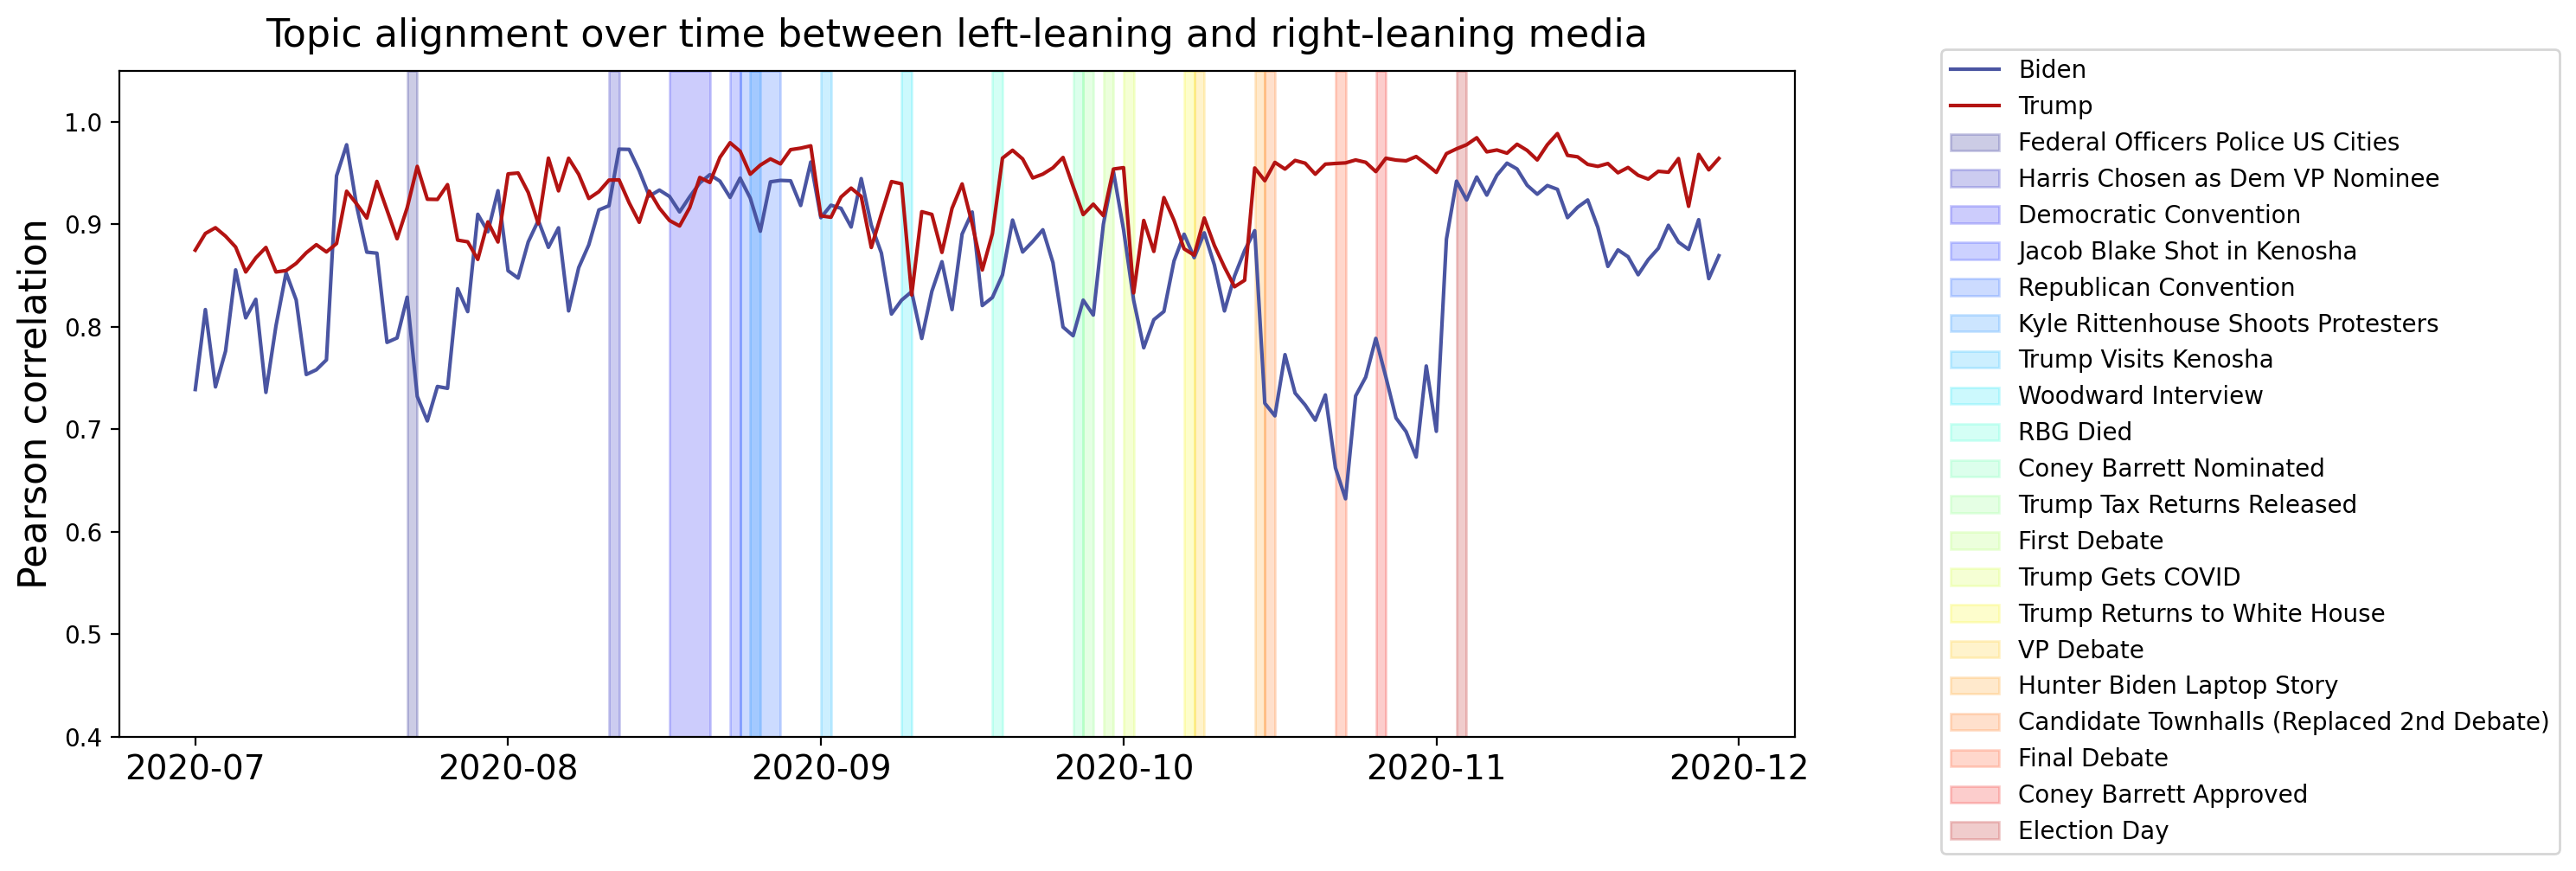

In [23]:
import matplotlib.cm as cm

dates = topvecs_df2020["headline"][0][1]["date"].tolist()

fig, ax = plt.subplots(figsize=(12.5,5))
plt.plot(dates, corrs_ideo1_2020, color=COLORMAP["left"], label="Biden")
plt.plot(dates, corrs_ideo2_2020, color=COLORMAP["right"], label="Trump")
for i,row in events_2020.iterrows():
    ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))
plt.ylim(.4,1.05)
plt.legend(bbox_to_anchor=(1.08, 1.05))
plt.ylabel("Pearson correlation", fontsize=16)
plt.title("Topic alignment over time between left-leaning and right-leaning media", fontsize=16, pad=10)
plt.xticks(fontsize=14)
plt.savefig(OUTPUT_FPATH + "tmp_topic_alignment_ideo_domains2020.pdf", dpi=300, bbox_inches="tight")

## Get before and after comparisons

### 2016

In [17]:
# topvecs_df2016["headline"][1][1].loc[130:]

In [18]:
# DAY1 = 141
# DAY2 = 143

# DAY1_LABEL = str(topvecs_df2016["headline"][1][1].loc[DAY1]["date"].date())
# DAY2_LABEL = str(topvecs_df2016["headline"][1][1].loc[DAY2]["date"].date())
# # DAY2 = 
# TOPICS2DROP_IDX = TOPICS2DROP_IDX2016
# df = pd.DataFrame()
# df["topic"] = dictionary2016.topics
# prop_lowc_day1 = topvecs_df2016["headline"][1][1].loc[DAY1]["majority_topvec"]
# prop_trad_day1 = topvecs_df2016["headline"][1][2].loc[DAY1]["majority_topvec"]
# prop_lowc_day2 = topvecs_df2016["headline"][1][1].loc[DAY2]["majority_topvec"]
# prop_trad_day2 = topvecs_df2016["headline"][1][2].loc[DAY2]["majority_topvec"]
# df["prop_lowc_day1"] = prop_lowc_day1
# df["prop_trad_day1"] = prop_trad_day1
# df["prop_lowc_day2"] = prop_lowc_day2
# df["prop_trad_day2"] = prop_trad_day2

# corr_cred_day1,_ = get_correlation(prop_lowc_day1, prop_trad_day1, TOPICS2DROP_IDX)
# corr_cred_day2,_ = get_correlation(prop_lowc_day2, prop_trad_day2, TOPICS2DROP_IDX)
# print(DAY1_LABEL, "before:", corr_cred_day1)
# print(DAY2_LABEL, "after:", corr_cred_day2)

In [19]:
# fig,ax = plt.subplots(figsize=(10,5), ncols=2, sharex=True, sharey=True)
# DAY1_LABEL = str(topvecs_df2016["headline"][1][1].loc[DAY1]["date"].date())
# DAY2_LABEL = str(topvecs_df2016["headline"][1][1].loc[DAY2]["date"].date())
# texts = [ABBR_MAP[x] for x in df["topic"]]
# for i in [0,1]:
#     ax[i].plot([-1,1],[-1,1], color="lightgrey", linestyle="--")
#     ax[i].set_xlim(1e-3, 1)
#     ax[i].set_ylim(1e-3, 1)
#     ax[i].set_xscale("log")
#     ax[i].set_yscale("log")
#     X = df[f"prop_lowc_day{i+1}"]
#     Y = df[f"prop_trad_day{i+1}"]
#     for x,y,t in zip(X, Y, texts):
#         if x > 1e-3  and y > 1e-3:
#             ax[i].text(x,y,t, color=COLORMAP["left"])
#     ax[i].scatter(df[f"prop_lowc_day{i+1}"], df[f"prop_trad_day{i+1}"], marker=".", color=COLORMAP["left"])
#     ax[i].set_xlabel("Topic proportion in low-cred domains", fontsize=12)
#     ax[i].set_ylabel("Topic proportion in trad domains", fontsize=12)   
# for i,(day, corr) in enumerate(zip([DAY1_LABEL, DAY2_LABEL], [corr_cred_day1, corr_cred_day2])):
#     ax[i].set_title(f"{day}\ncorr = {round(corr,4)}", fontsize=12)
# plt.tight_layout()
# # plt.savefig(OUTPUT_FPATH + F"compare_days_{DAY1}_{DAY2}_clinton2016_cred.png", dpi=300, bbox_inches="tight")

In [20]:
# # DAY1 = 65
# # DAY2 = 67
# # TOPICS2DROP_IDX = TOPICS2DROP_IDX2016
# df = pd.DataFrame()
# df["topic"] = dictionary2016.topics
# prop_left_day1 = topvecs_df2016["headline"][1][3].loc[DAY1]["majority_topvec"]
# prop_right_day1 = topvecs_df2016["headline"][1][5].loc[DAY1]["majority_topvec"]
# prop_left_day2 = topvecs_df2016["headline"][1][3].loc[DAY2]["majority_topvec"]
# prop_right_day2 = topvecs_df2016["headline"][1][5].loc[DAY2]["majority_topvec"]
# df["prop_left_day1"] = prop_left_day1
# df["prop_right_day1"] = prop_right_day1
# df["prop_left_day2"] = prop_left_day2
# df["prop_right_day2"] = prop_right_day2

# corr_ideo_day1,_ = get_correlation(prop_left_day1, prop_right_day1, TOPICS2DROP_IDX)
# corr_ideo_day2,_ = get_correlation(prop_left_day2, prop_right_day2, TOPICS2DROP_IDX)
# print("before:", corr_ideo_day1)
# print("after:", corr_ideo_day2)

In [21]:
# fig,ax = plt.subplots(figsize=(10,5), ncols=2, sharex=True, sharey=True)
# DAY1_LABEL = str(topvecs_df2016["headline"][1][1].loc[DAY1]["date"].date())
# DAY2_LABEL = str(topvecs_df2016["headline"][1][1].loc[DAY2]["date"].date())
# texts = [ABBR_MAP[x] for x in df["topic"]]
# for i in [0,1]:
#     ax[i].plot([-1,1],[-1,1], color="lightgrey", linestyle="--")
#     ax[i].set_xlim(1e-3, 1)
#     ax[i].set_ylim(1e-3, 1)
#     ax[i].set_xscale("log")
#     ax[i].set_yscale("log")
#     X = df[f"prop_left_day{i+1}"]
#     Y = df[f"prop_right_day{i+1}"]
#     for x,y,t in zip(X, Y, texts):
#         if x > 1e-3  and y > 1e-3:
#             ax[i].text(x,y,t, color=COLORMAP["left"])
#     ax[i].scatter(df[f"prop_left_day{i+1}"], df[f"prop_right_day{i+1}"], marker=".", color=COLORMAP["left"])
#     ax[i].set_xlabel("Topic proportion in left domains", fontsize=12)
#     ax[i].set_ylabel("Topic proportion in right domains", fontsize=12)   
# for i,(day, corr) in enumerate(zip([DAY1_LABEL, DAY2_LABEL], [corr_ideo_day1, corr_ideo_day2])):
#     ax[i].set_title(f"{day}\ncorr = {round(corr,4)}", fontsize=12)
# plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + F"compare_days_{DAY1}_{DAY2}_clinton2016_ideo.png", dpi=300, bbox_inches="tight")

### 2020

In [24]:
topvecs_df2020["headline"][1][1].loc[80:110]

date                                    majority_topvec
80  2020-09-19  [0.12460022173320215, 0.0, 0.02120911493179323...
81  2020-09-20  [0.12382109052130631, 0.0, 0.01891105599431908...
82  2020-09-21  [0.12088756495985555, 0.0, 0.02074323761292744...
83  2020-09-22  [0.11705215901393609, 0.0, 0.01889671522655412...
84  2020-09-23  [0.11925843391678512, 0.0, 0.01992623432889185...
85  2020-09-24  [0.10999392488533952, 0.0, 0.02149120004480458...
86  2020-09-25  [0.10838520690101087, 0.0, 0.01842103224345060...
87  2020-09-26  [0.1017510519505784, 0.0, 0.017838904782989454...
88  2020-09-27  [0.09578417850583258, 0.0, 0.01899603025894752...
89  2020-09-28  [0.10269272912555845, 0.0, 0.02404142462723907...
90  2020-09-29  [0.09989390013523647, 0.0, 0.02408029200730914...
91  2020-09-30  [0.10155819656626633, 0.0, 0.02518821959316328...
92  2020-10-01  [0.098033032182267, 0.0, 0.024100969341770865,...
93  2020-10-02  [0.15929964426213453, 0.0, 0.02037925162671063...
94  2020-10-03  [0.27306788332046894, 0.0, 0.01769925349288473...
95  2020-10-04  [0.25756162484678147, 0.0, 0.01717429791874459...
96  2020-10-05  [0.2884867191834264, 0.0, 0.019604336092875905...
97  2020-10-06  [0.2764927081500724, 0.0, 0.019171522858334185...
98  2020-10-07  [0.2420807959729948, 0.0, 0.017477135862280967...
99  2020-10-08  [0.19367744661304587, 0.0, 0.01928767548352292...
100 2020-10-09  [0.18722853418895663, 0.0, 0.01767474976397542...
101 2020-10-10  [0.18389849524813182, 0.0, 0.01859216153076824...
102 2020-10-11  [0.1711932622495547, 0.0, 0.019778512947363304...
103 2020-10-12  [0.15793043473047577, 0.0, 0.02153329197997089...
104 2020-10-13  [0.1594406484086381, 0.0, 0.019424271441292242...
105 2020-10-14  [0.17931412318981013, 0.0, 0.01762049425598589...
106 2020-10-15  [0.15228924869256993, 0.0, 0.02260248458370678...
107 2020-10-16  [0.14033967201949787, 0.0, 0.02380409615474917...
108 2020-10-17  [0.13635640679124267, 0.0, 0.02278734591843045...
109 2020-10-18  [0.13578392449041873, 0.0, 0.02545143129129849...
110 2020-10-19  [0.13902501579319668, 0.0, 0.03219515888585309...

In [40]:
DAY1 = 92	
DAY2 = 93

DAY1_LABEL = str(topvecs_df2020["headline"][1][1].loc[DAY1]["date"].date())
DAY2_LABEL = str(topvecs_df2020["headline"][1][1].loc[DAY2]["date"].date())
# DAY2 = 
TOPICS2DROP_IDX = TOPICS2DROP_IDX2020
df = pd.DataFrame()
df["topic"] = dictionary2020.topics
prop_lowc_day1 = topvecs_df2020["headline"][1][1].loc[DAY1]["majority_topvec"]
prop_trad_day1 = topvecs_df2020["headline"][1][2].loc[DAY1]["majority_topvec"]
prop_lowc_day2 = topvecs_df2020["headline"][1][1].loc[DAY2]["majority_topvec"]
prop_trad_day2 = topvecs_df2020["headline"][1][2].loc[DAY2]["majority_topvec"]
df["prop_lowc_day1"] = prop_lowc_day1
df["prop_trad_day1"] = prop_trad_day1
df["prop_lowc_day2"] = prop_lowc_day2
df["prop_trad_day2"] = prop_trad_day2

corr_cred_day1,_ = get_correlation(prop_lowc_day1, prop_trad_day1, TOPICS2DROP_IDX)
corr_cred_day2,_ = get_correlation(prop_lowc_day2, prop_trad_day2, TOPICS2DROP_IDX)
print(DAY1_LABEL, "before:", corr_cred_day1)
print(DAY2_LABEL, "after:", corr_cred_day2)

2020-10-01 before: 0.9561560441801328
2020-10-02 after: 0.6587906726309339


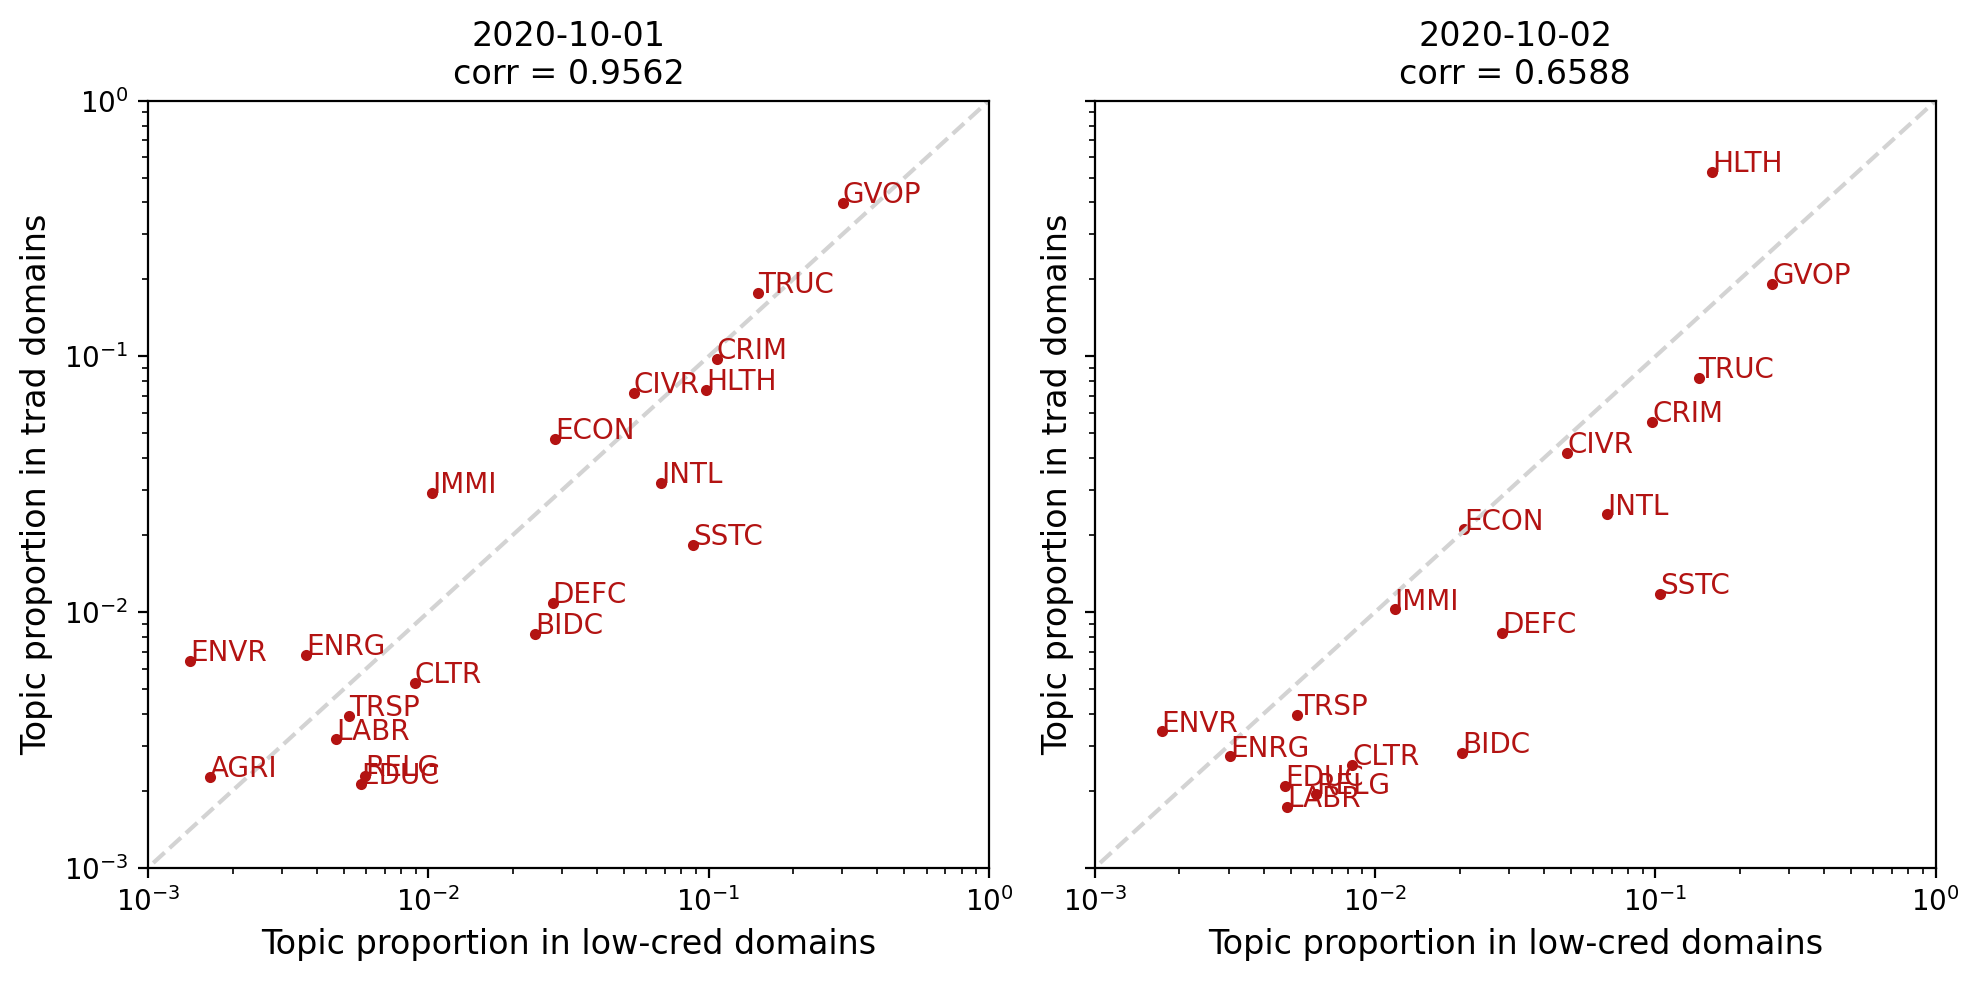

In [41]:
fig,ax = plt.subplots(figsize=(10,5), ncols=2, sharex=True, sharey=True)
DAY1_LABEL = str(topvecs_df2020["headline"][0][1].loc[DAY1]["date"].date())
DAY2_LABEL = str(topvecs_df2020["headline"][0][1].loc[DAY2]["date"].date())
texts = [ABBR_MAP[x] for x in df["topic"]]
for i in [0,1]:
    ax[i].plot([-1,1],[-1,1], color="lightgrey", linestyle="--")
    ax[i].set_xlim(1e-3, 1)
    ax[i].set_ylim(1e-3, 1)
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    X = df[f"prop_lowc_day{i+1}"]
    Y = df[f"prop_trad_day{i+1}"]
    for x,y,t in zip(X, Y, texts):
        if x > 1e-3  and y > 1e-3:
            # ax[i].text(x,y,t, color=COLORMAP["left"])
            ax[i].text(x,y,t, color=COLORMAP["right"])
    # ax[i].scatter(df[f"prop_lowc_day{i+1}"], df[f"prop_trad_day{i+1}"], marker=".", color=COLORMAP["left"])
    ax[i].scatter(df[f"prop_lowc_day{i+1}"], df[f"prop_trad_day{i+1}"], marker=".", color=COLORMAP["right"])
    ax[i].set_xlabel("Topic proportion in low-cred domains", fontsize=12)
    ax[i].set_ylabel("Topic proportion in trad domains", fontsize=12)   
for i,(day, corr) in enumerate(zip([DAY1_LABEL, DAY2_LABEL], [corr_cred_day1, corr_cred_day2])):
    ax[i].set_title(f"{day}\ncorr = {round(corr,4)}", fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_FPATH + F"compare_days_{DAY1}_{DAY2}_trump2020_cred.png", dpi=300, bbox_inches="tight")

In [42]:
# DAY1 = 65
# DAY2 = 67
# TOPICS2DROP_IDX = TOPICS2DROP_IDX2020
df = pd.DataFrame()
df["topic"] = dictionary2020.topics
prop_left_day1 = topvecs_df2020["headline"][1][3].loc[DAY1]["majority_topvec"]
prop_right_day1 = topvecs_df2020["headline"][1][5].loc[DAY1]["majority_topvec"]
prop_left_day2 = topvecs_df2020["headline"][1][3].loc[DAY2]["majority_topvec"]
prop_right_day2 = topvecs_df2020["headline"][1][5].loc[DAY2]["majority_topvec"]
df["prop_left_day1"] = prop_left_day1
df["prop_right_day1"] = prop_right_day1
df["prop_left_day2"] = prop_left_day2
df["prop_right_day2"] = prop_right_day2

corr_ideo_day1,_ = get_correlation(prop_left_day1, prop_right_day1, TOPICS2DROP_IDX)
corr_ideo_day2,_ = get_correlation(prop_left_day2, prop_right_day2, TOPICS2DROP_IDX)
print("before:", corr_ideo_day1)
print("after:", corr_ideo_day2)

before: 0.9553681862303061
after: 0.8331282183466467


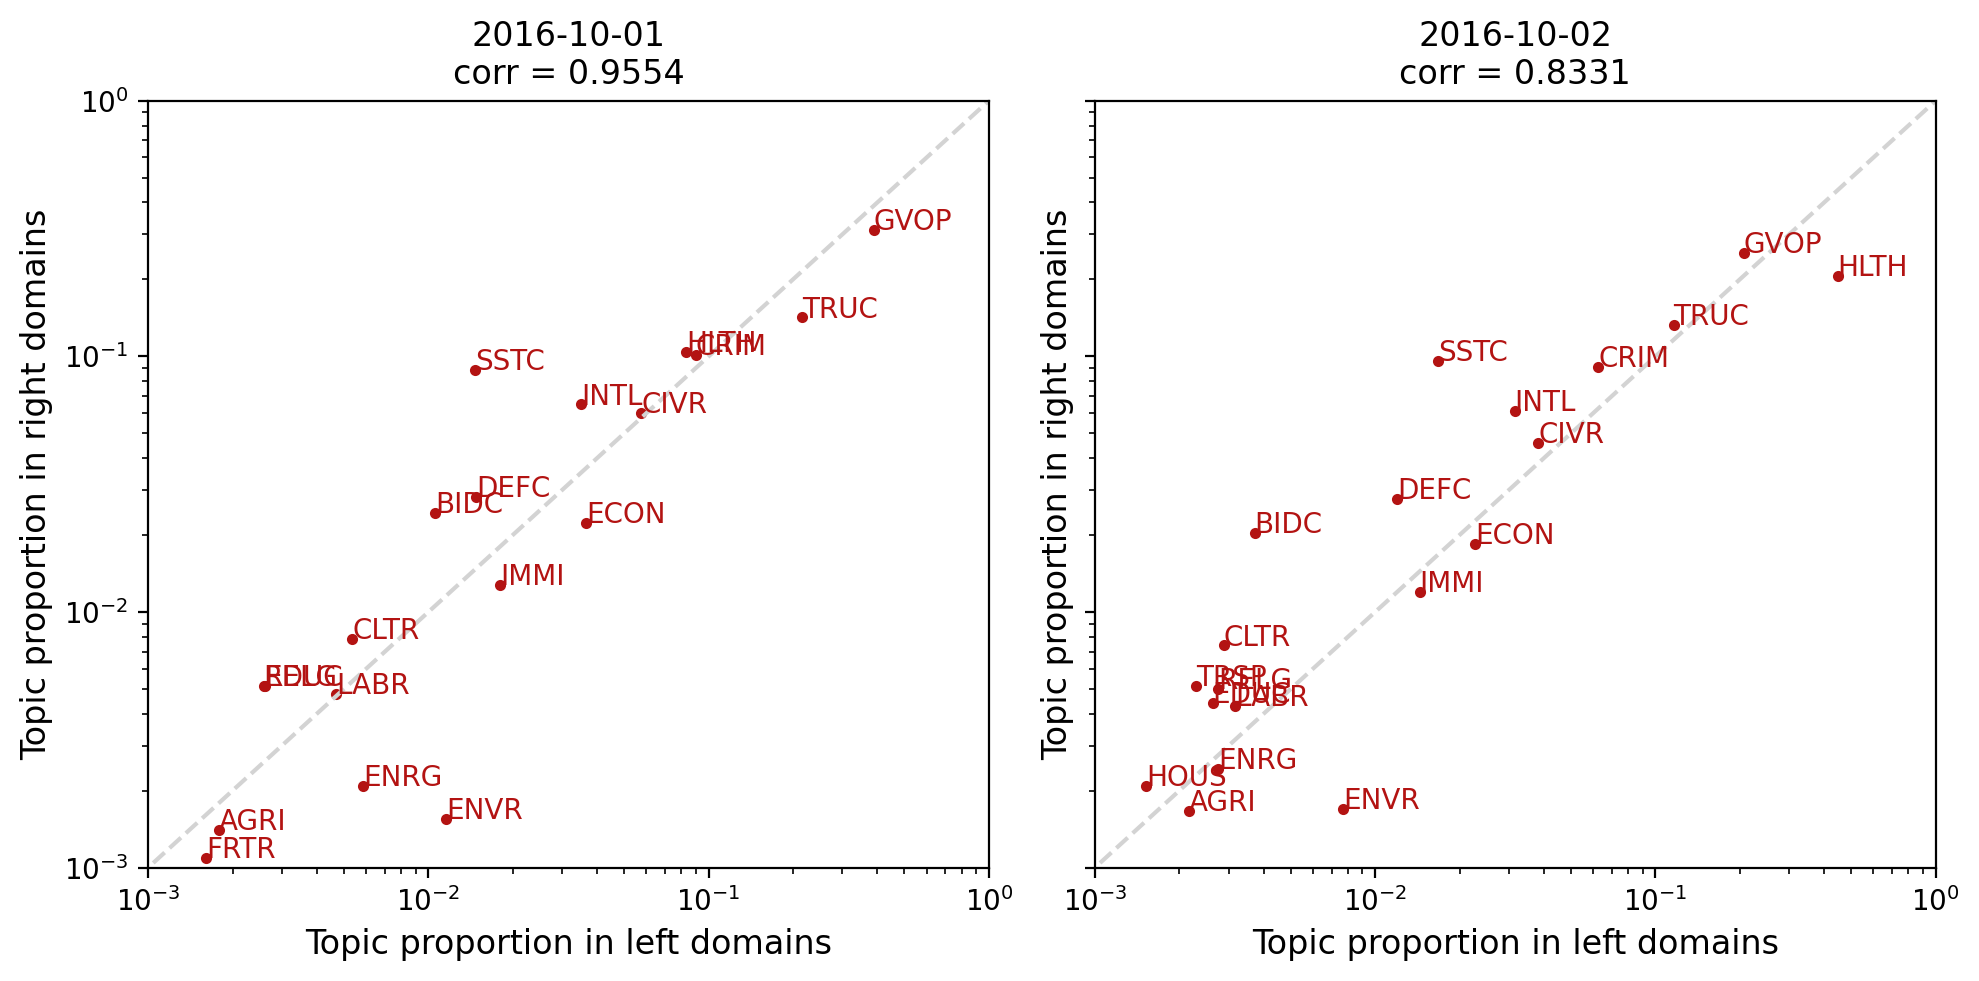

In [43]:
fig,ax = plt.subplots(figsize=(10,5), ncols=2, sharex=True, sharey=True)
DAY1_LABEL = str(topvecs_df2016["headline"][0][1].loc[DAY1]["date"].date())
DAY2_LABEL = str(topvecs_df2016["headline"][0][1].loc[DAY2]["date"].date())
texts = [ABBR_MAP[x] for x in df["topic"]]
for i in [0,1]:
    ax[i].plot([-1,1],[-1,1], color="lightgrey", linestyle="--")
    ax[i].set_xlim(1e-3, 1)
    ax[i].set_ylim(1e-3, 1)
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    X = df[f"prop_left_day{i+1}"]
    Y = df[f"prop_right_day{i+1}"]
    for x,y,t in zip(X, Y, texts):
        if x > 1e-3  and y > 1e-3:
            ax[i].text(x,y,t, color=COLORMAP["right"])
    ax[i].scatter(df[f"prop_left_day{i+1}"], df[f"prop_right_day{i+1}"], marker=".", color=COLORMAP["right"])
    ax[i].set_xlabel("Topic proportion in left domains", fontsize=12)
    ax[i].set_ylabel("Topic proportion in right domains", fontsize=12)   
for i,(day, corr) in enumerate(zip([DAY1_LABEL, DAY2_LABEL], [corr_ideo_day1, corr_ideo_day2])):
    ax[i].set_title(f"{day}\ncorr = {round(corr,4)}", fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_FPATH + F"compare_days_{DAY1}_{DAY2}_trump2020_ideo.png", dpi=300, bbox_inches="tight")

## Viualizing difference

In [68]:
TOPIC_COLORMAP = {
    "clinton_controversies":"#A2678A",
    "biden_controversies":"#A2678A",
    "government_ops":"#141E46",
    "healthcare":"#5B9A8B",
    "crime":"#F94C10",
    "civil_rights":"#FD8D14",
    "economy":"#7D7463",
    "sstc":"#A1CCD1",
    "trump_controversies":"#C70039",
}

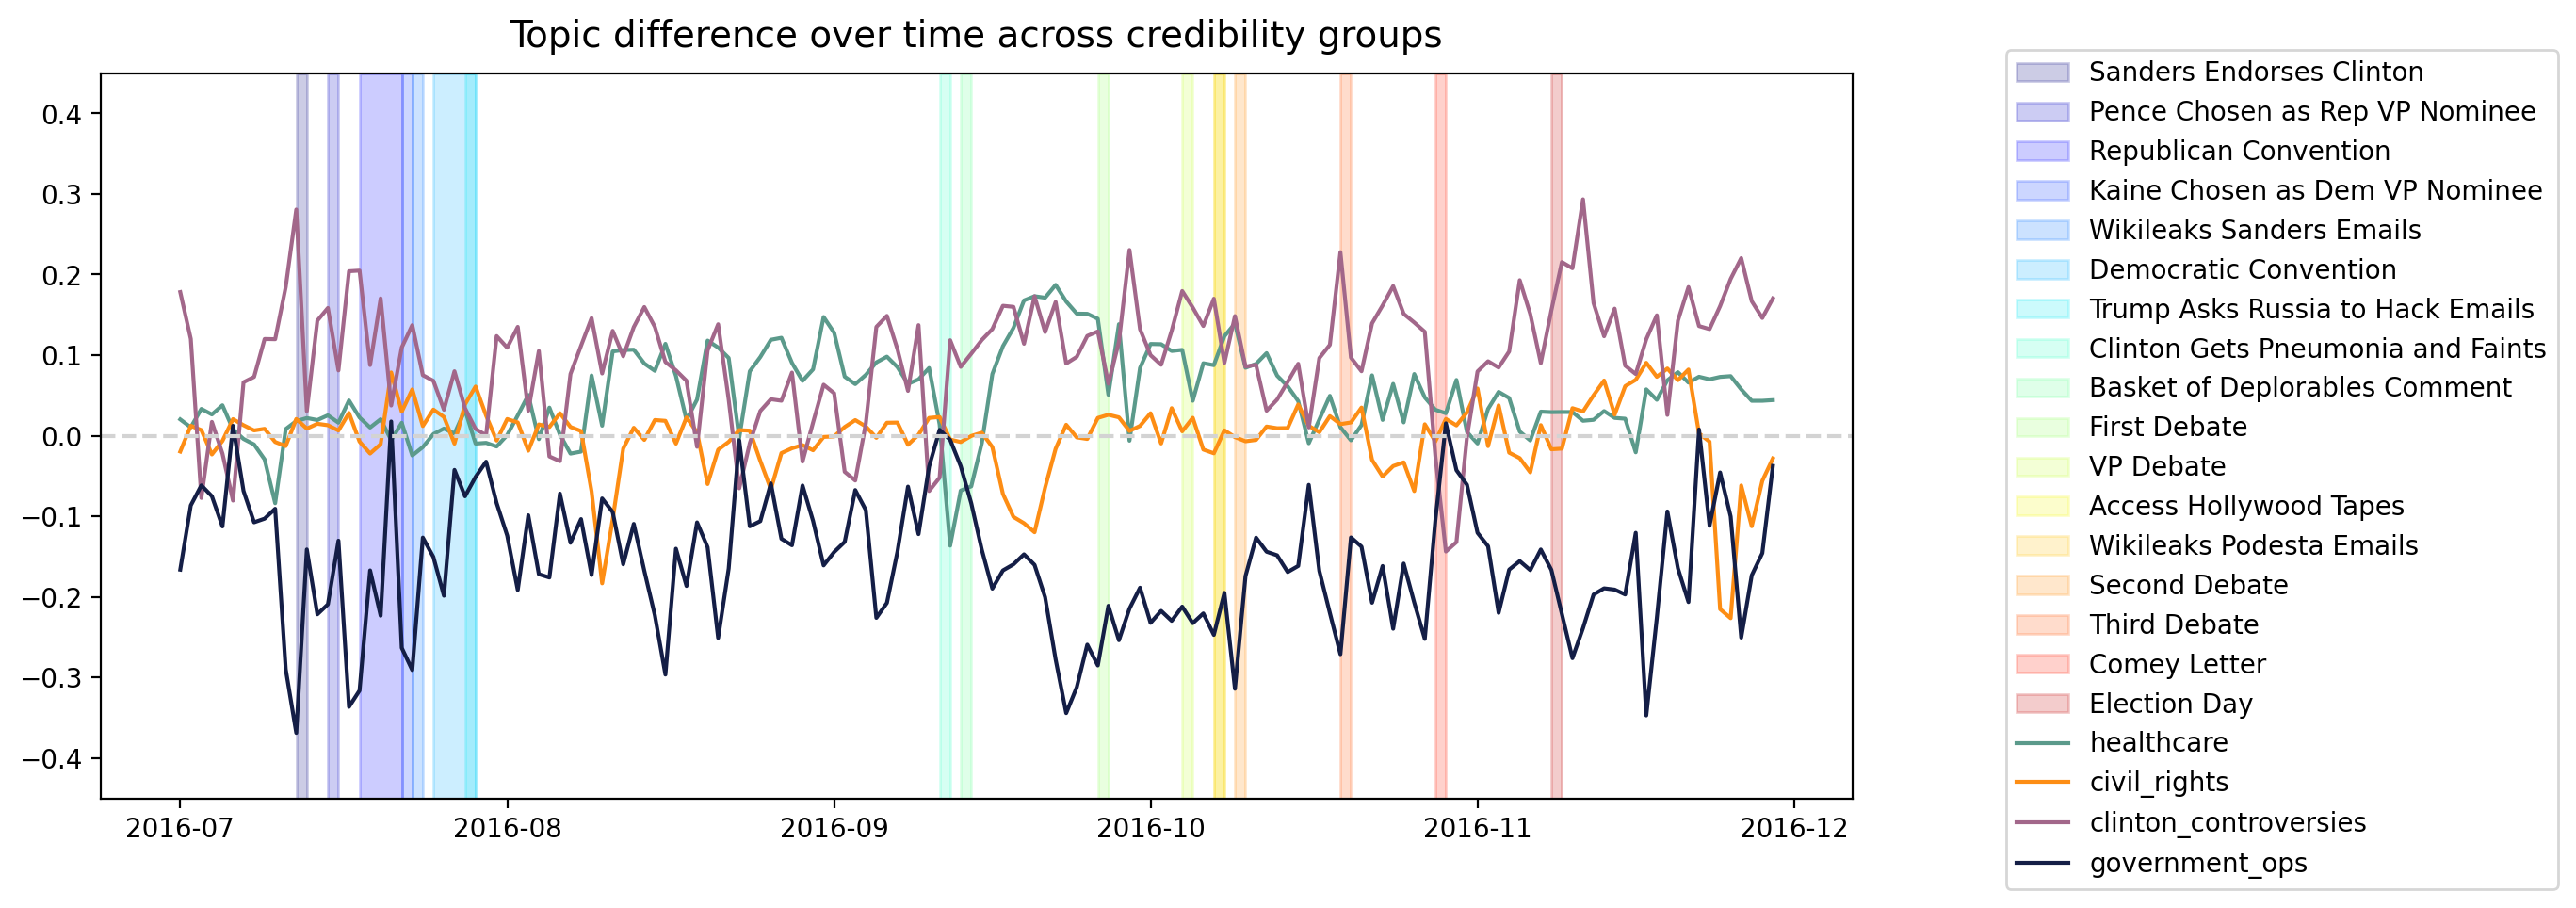

In [73]:
dictionary = dictionary2016
topvec_df1 = topvecs_df2016["headline"][1][1]
topvec_df2 = topvecs_df2016["headline"][1][2]
KEY_TOPICS = [
    "clinton_controversies",
    "government_ops",
    "healthcare",
    "civil_rights",
    # "economy",
]
fig, ax = plt.subplots(figsize=(12,5))
dates = topvecs_df2016["headline"][0][1]["date"].tolist()

for i,row in events_2016.iterrows():
    ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))
for topic in dictionary.topics:
    if topic in KEY_TOPICS:
        topic_arr1 = np.array(topvec_df1["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_arr2 = np.array(topvec_df2["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_diff = topic_arr1 - topic_arr2
        plt.plot(dates, topic_diff, label=topic, color=TOPIC_COLORMAP[topic])
plt.axhline(y=0, color="lightgrey", linestyle="--")
plt.ylim(-.45, .45)
plt.legend(bbox_to_anchor=(1.08, 1.05))
plt.title("Topic difference over time across credibility groups", fontsize=14, pad=10)
plt.savefig(OUTPUT_FPATH + "tmp_topic_diff_cred_domains2016.png", dpi=300, bbox_inches="tight")

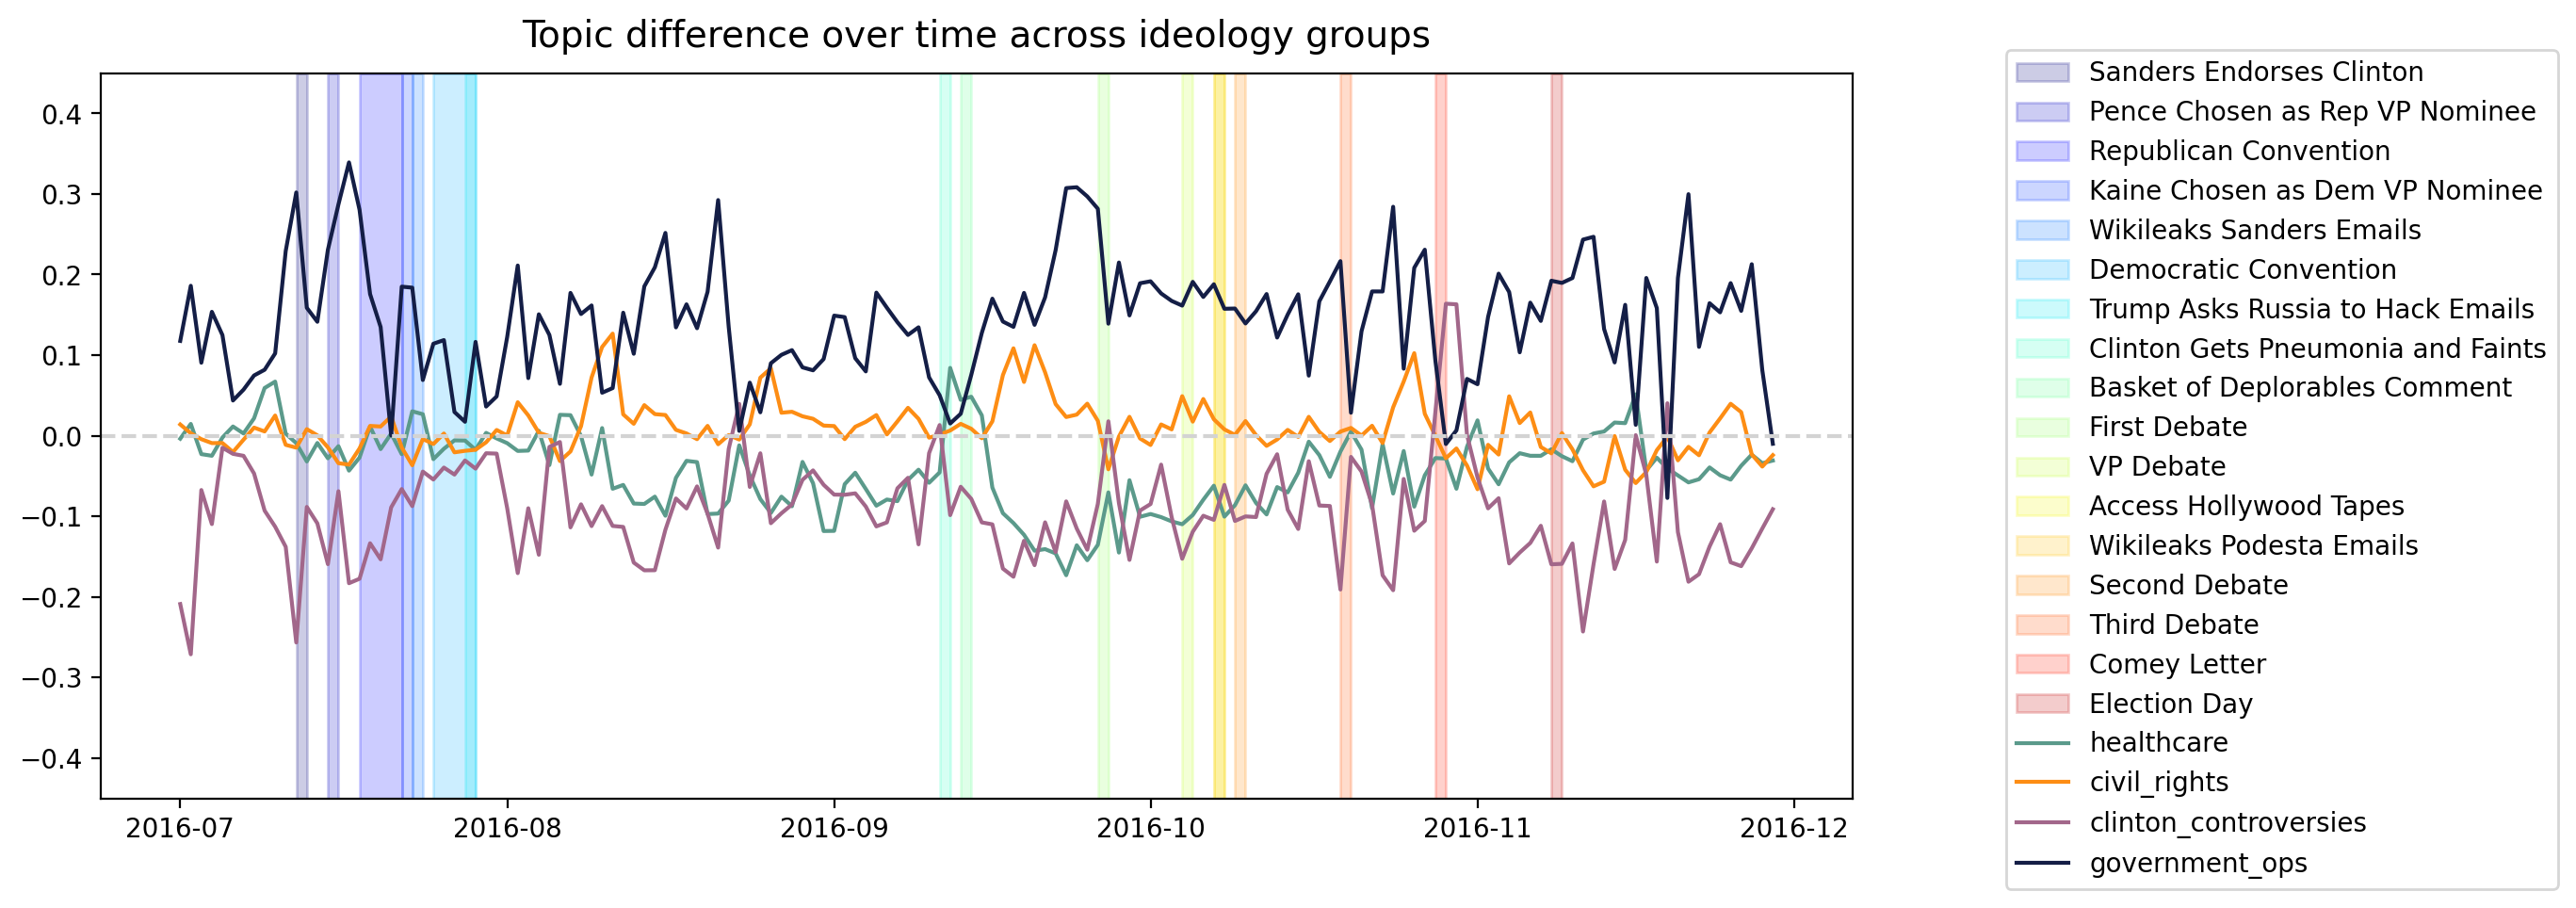

In [74]:
dictionary = dictionary2016
topvec_df1 = topvecs_df2016["headline"][1][3]
topvec_df2 = topvecs_df2016["headline"][1][5]
KEY_TOPICS = [
    "clinton_controversies",
    "government_ops",
    "healthcare",
    "civil_rights",
    # "economy",
]
fig, ax = plt.subplots(figsize=(12,5))
dates = topvecs_df2016["headline"][0][1]["date"].tolist()

for i,row in events_2016.iterrows():
    ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))
for topic in dictionary.topics:
    if topic in KEY_TOPICS:
        topic_arr1 = np.array(topvec_df1["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_arr2 = np.array(topvec_df2["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_diff = topic_arr1 - topic_arr2
        plt.plot(dates, topic_diff, label=topic, color=TOPIC_COLORMAP[topic])
plt.axhline(y=0, color="lightgrey", linestyle="--")
plt.ylim(-.45, .45)
plt.legend(bbox_to_anchor=(1.08, 1.05))
plt.title("Topic difference over time across ideology groups", fontsize=14, pad=10)
plt.savefig(OUTPUT_FPATH + "tmp_topic_diff_ideo_domains2016.png", dpi=300, bbox_inches="tight")

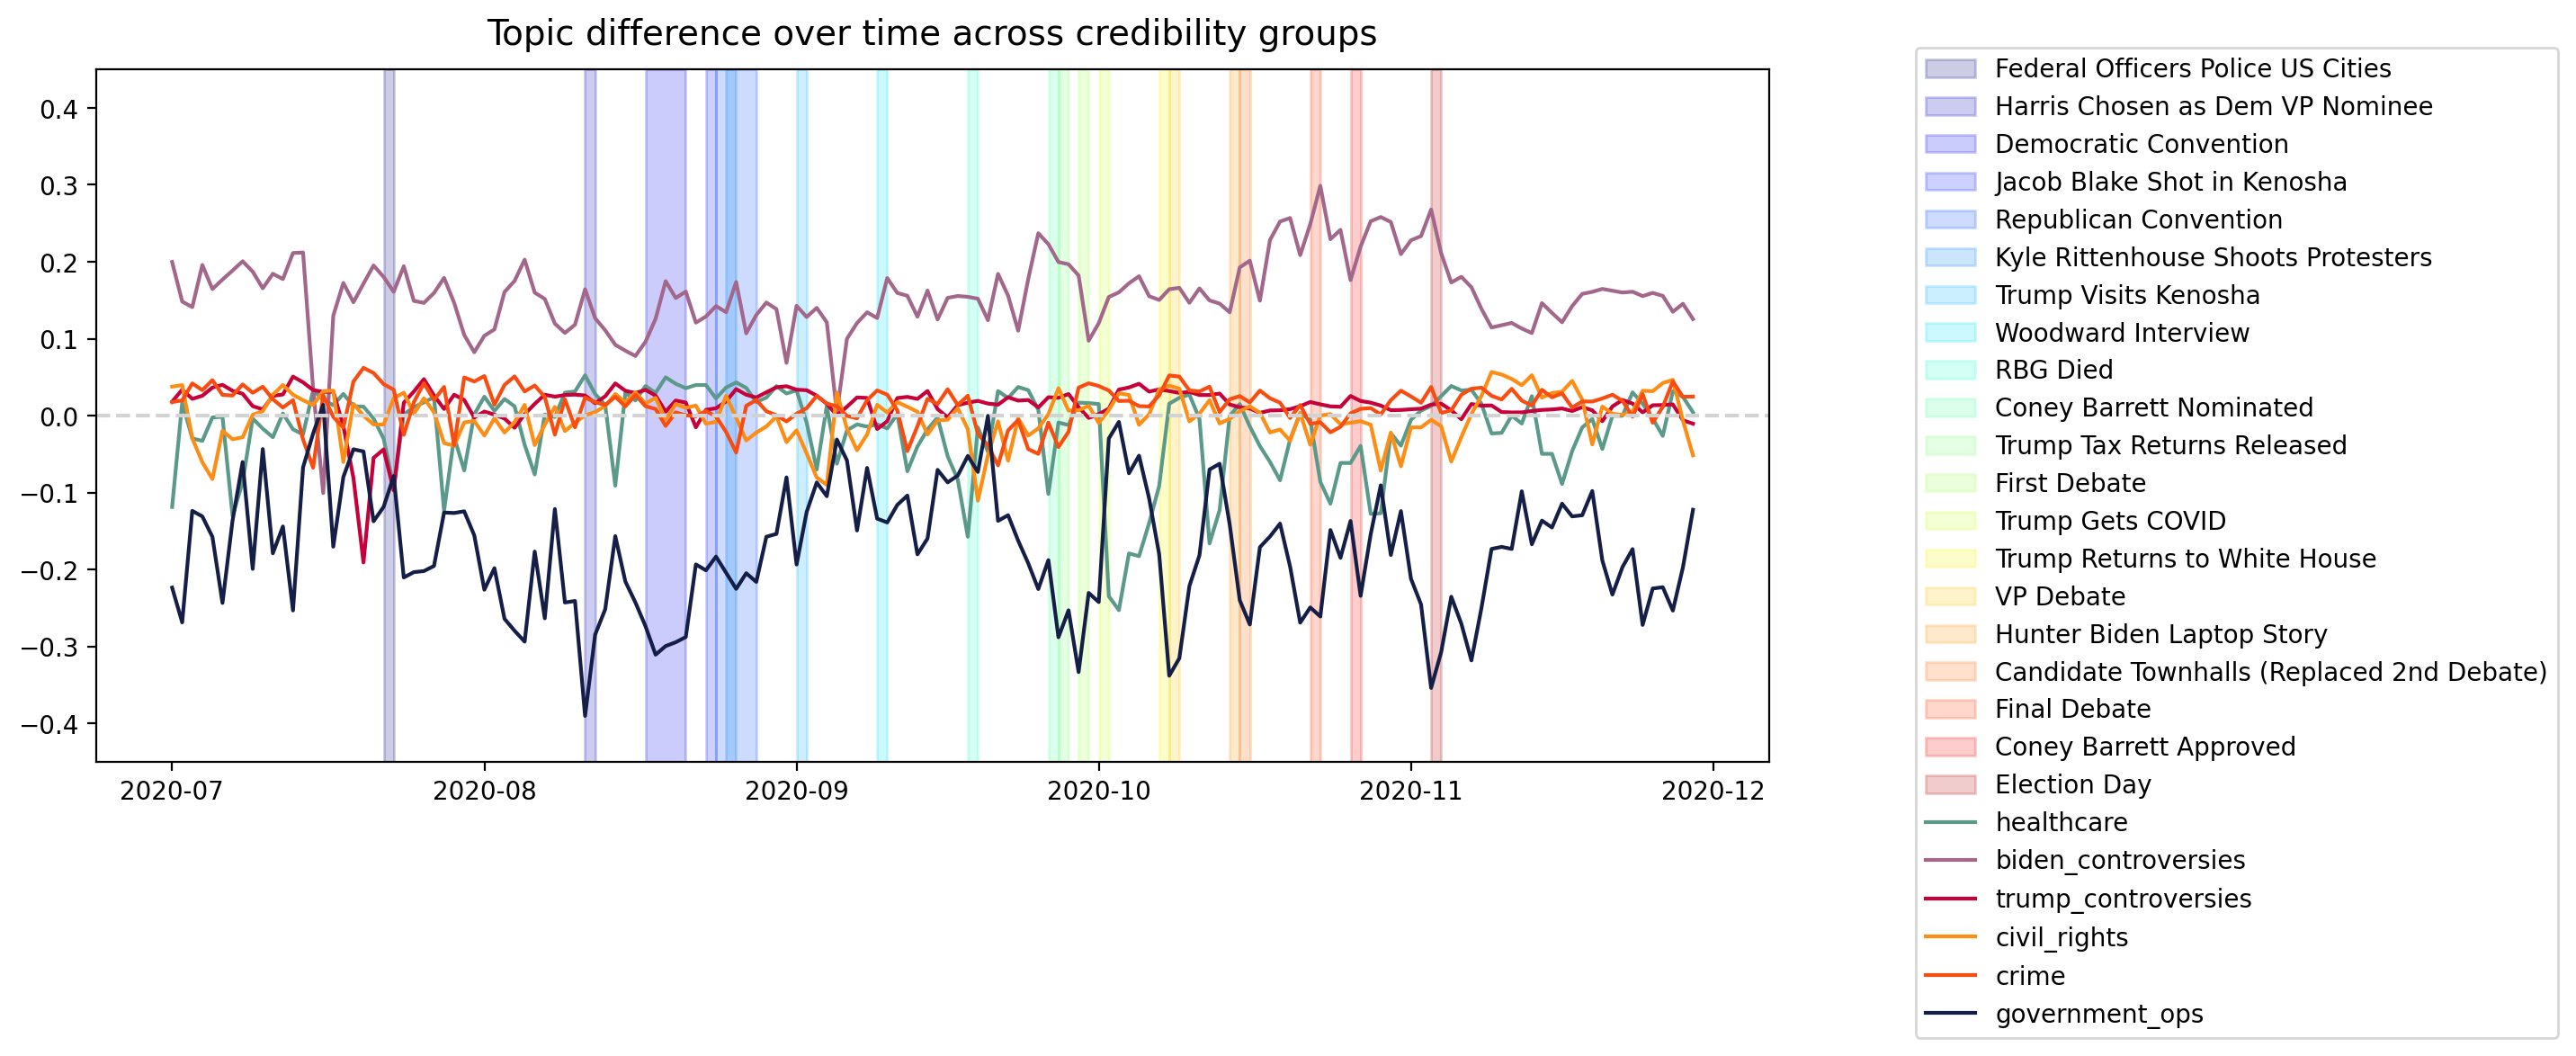

In [78]:
dictionary = dictionary2020
topvec_df1 = topvecs_df2020["headline"][0][1]
topvec_df2 = topvecs_df2020["headline"][0][2]
KEY_TOPICS = [
    "biden_controversies",
    "trump_controversies",
    "government_ops",
    "healthcare",
    "civil_rights",
    # "crime",
]
fig, ax = plt.subplots(figsize=(12,5))
dates = topvecs_df2020["headline"][0][1]["date"].tolist()

for i,row in events_2020.iterrows():
    ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))
for topic in dictionary.topics:
    if topic in KEY_TOPICS:
        topic_arr1 = np.array(topvec_df1["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_arr2 = np.array(topvec_df2["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_diff = topic_arr1 - topic_arr2
        plt.plot(dates, topic_diff, label=topic, color=TOPIC_COLORMAP[topic])
plt.axhline(y=0, color="lightgrey", linestyle="--")
plt.ylim(-.45, .45)
plt.legend(bbox_to_anchor=(1.08, 1.05))
plt.title("Topic difference over time across credibility groups", fontsize=14, pad=10)
plt.savefig(OUTPUT_FPATH + "tmp_topic_diff_cred_domains2020.png", dpi=300, bbox_inches="tight")

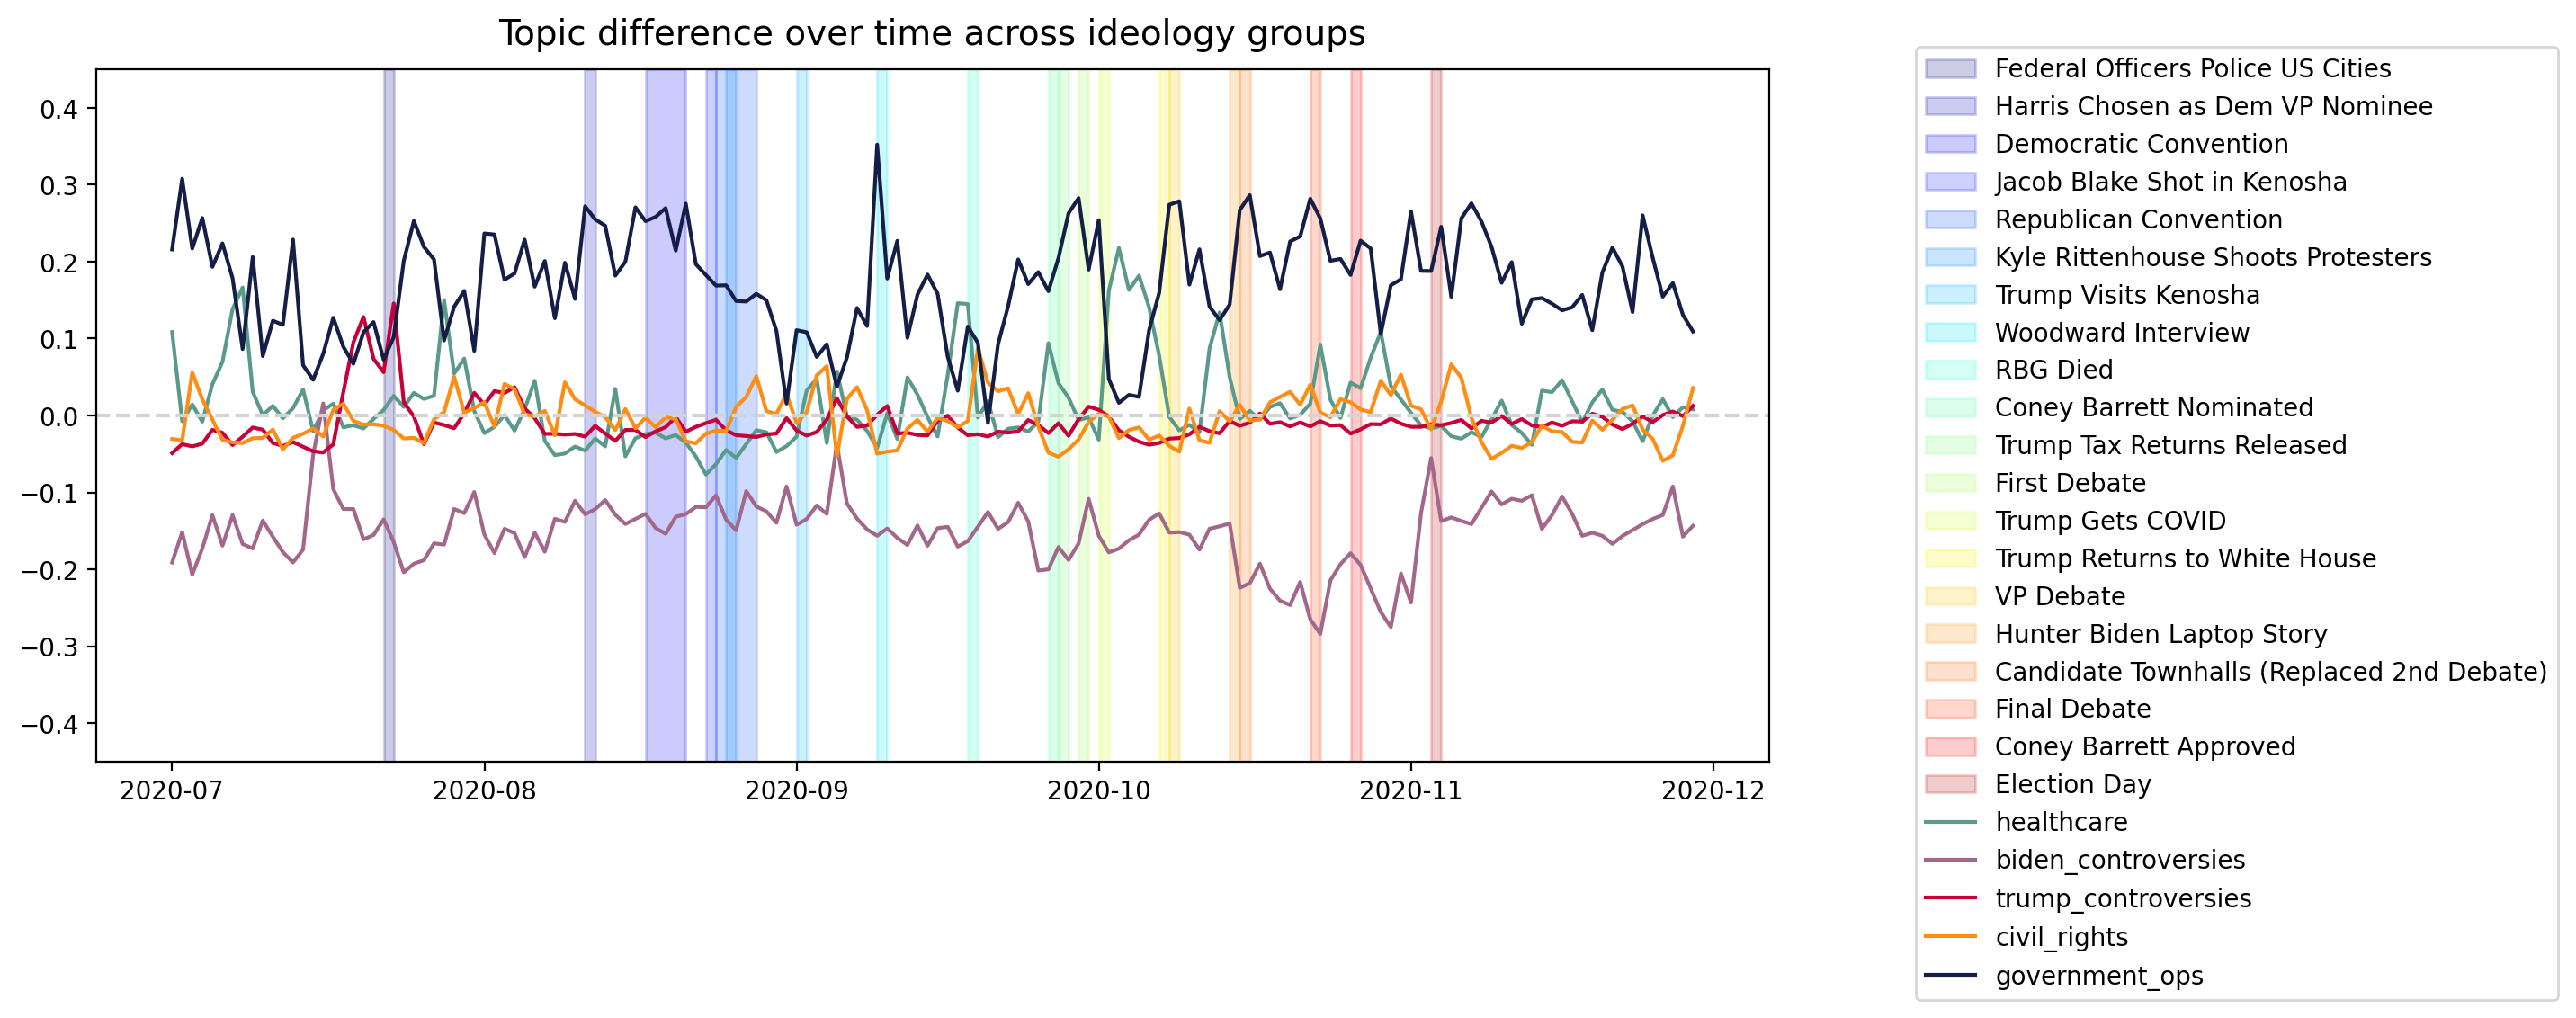

In [80]:
dictionary = dictionary2020
topvec_df1 = topvecs_df2020["headline"][0][3]
topvec_df2 = topvecs_df2020["headline"][0][5]
KEY_TOPICS = [
    "biden_controversies",
    "trump_controversies",
    "government_ops",
    "healthcare",
    "civil_rights",
    # "crime",
]
fig, ax = plt.subplots(figsize=(12,5))
dates = topvecs_df2020["headline"][0][1]["date"].tolist()

for i,row in events_2020.iterrows():
    ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))
for topic in dictionary.topics:
    if topic in KEY_TOPICS:
        topic_arr1 = np.array(topvec_df1["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_arr2 = np.array(topvec_df2["majority_topvec"].tolist())[:,dictionary.topic2index[topic]]
        topic_diff = topic_arr1 - topic_arr2
        plt.plot(dates, topic_diff, label=topic, color=TOPIC_COLORMAP[topic])
plt.axhline(y=0, color="lightgrey", linestyle="--")
plt.ylim(-.45, .45)
plt.legend(bbox_to_anchor=(1.08, 1.05))
plt.title("Topic difference over time across ideology groups", fontsize=14, pad=10)
plt.savefig(OUTPUT_FPATH + "tmp_topic_diff_ideo_domains2020.png", dpi=300, bbox_inches="tight")